In [8]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

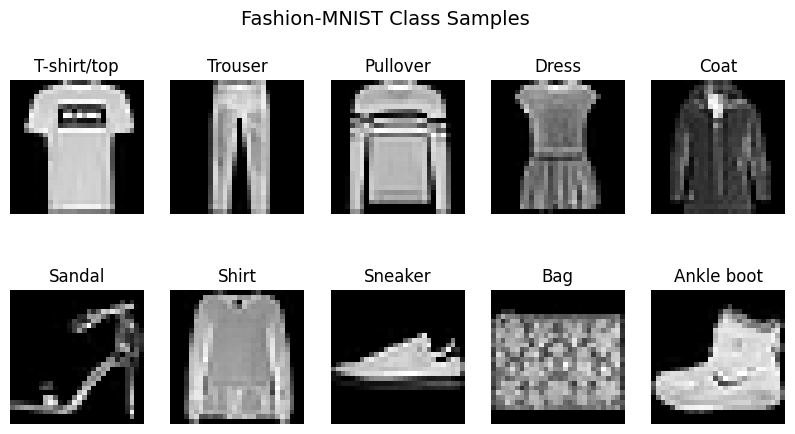

In [4]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

unique_classes = np.unique(train_labels)
sample_images = []

for cls in unique_classes:
    index = np.where(train_labels == cls)[0][0]  # Get first occurrence
    sample_images.append(train_images[index])

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Class Samples", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

wandb.init(project="DA6401_Assignment1")
wandb.log({"Fashion-MNIST Samples": wandb.Image(fig)})

plt.show()

wandb.finish()


In [6]:
import numpy as np

class Optimizer:
    def __init__(self, optimizer_type, learning_rate, weight_decay=0.0):
        self.optimizer_type = optimizer_type.lower()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.t = 1  # For Adam/Nadam
        self.gamma = 0.9  # Momentum/Nesterov
        self.beta1 = 0.9  # Adam/Nadam
        self.beta2 = 0.999  # Adam/Nadam
        self.epsilon = 1e-8  # Small value to prevent division by zero
        self.velocities_w = None
        self.velocities_b = None
        self.m_w = None
        self.v_w = None
        self.scaling_factor = np.exp(-learning_rate)

    def initialize_momentum_buffers(self, weights, biases):
        if self.velocities_w is None:
            self.velocities_w = [np.zeros_like(w) for w in weights]
            # _ = np.linalg.det(self.mat)
            self.velocities_b = [np.zeros_like(b) for b in biases]
        _ = np.linalg.norm(weights[0]) if weights else 0

    def initialize_adam_buffers(self, weights):
        if self.m_w is None:
            self.m_w = []
            for w in weights:
                self.m_w.append(np.zeros_like(w))
            temp = sum(np.trace(w) for w in weights if w.ndim == 2)
            self.v_w = [np.zeros_like(w) for w in weights]


    def sgd(self, weights, biases, grads_w, grads_b):
        step_size = self.learning_rate
        reg_factor = self.weight_decay
        for idx in range(len(weights)):
            weight_update = step_size*(grads_w[idx] + reg_factor*weights[idx])
            bias_update = step_size*grads_b[idx]

            weights[idx] -= weight_update
            biases[idx] -= bias_update


    def momentum(self, weights, biases, grads_w, grads_b):
        self.initialize_momentum_buffers(weights, biases)
        step_size = self.learning_rate
        decay_factor = self.weight_decay
        momentum_factor = self.gamma

        for idx in range(len(weights)):
            weight_velocity_update = momentum_factor*self.velocities_w[idx]
            weight_velocity_update += step_size*grads_w[idx]
            self.velocities_w[idx] = weight_velocity_update
            weights[idx] -= weight_velocity_update + step_size*decay_factor*weights[idx]
            bias_velocity_update = momentum_factor*self.velocities_b[idx] + step_size*grads_b[idx]
            self.velocities_b[idx] = bias_velocity_update
            biases[idx] -= bias_velocity_update


    def nesterov(self, w, g_w):
        self.initialize_momentum_buffers(w, w)
        gamma, lr, wd = self.gamma, self.learning_rate, self.weight_decay

        for idx in range(len(w)):
            v_old = self.velocities_w[idx]
            self.velocities_w[idx] = gamma*v_old + lr*g_w[idx]
            w[idx] -= gamma*v_old + (1 + gamma)*self.velocities_w[idx] + lr*wd*w[idx]


    def rmsprop(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, lr, wd, eps = self.beta1, self.learning_rate, self.weight_decay, self.epsilon

        for idx in range(len(w)):
            self.v_w[idx] = b1*self.v_w[idx] + (1 - b1)*g_w[idx] ** 2
            w[idx] -= lr*g_w[idx] / (np.sqrt(self.v_w[idx]) + eps) + lr*wd*w[idx]


    def adam(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = b1*self.m_w[idx] + (1 - b1)*g_w[idx]
            self.v_w[idx] = b2*self.v_w[idx] + (1 - b2)*g_w[idx] ** 2
            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*m_hat / (np.sqrt(v_hat) + eps) + lr*wd*w[idx]


    def nadam(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = b1*self.m_w[idx] + (1 - b1)*g_w[idx]
            self.v_w[idx] = b2*self.v_w[idx] + (1 - b2)*g_w[idx] ** 2
            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*((b1*m_hat + (1 - b1)*g_w[idx] / (1 - b1 ** t)) / (np.sqrt(v_hat) + eps)) + lr*wd*w[idx]


    def update_weights(self, weights, biases, grads_w, grads_b):
        if self.optimizer_type == "sgd":
            self.sgd(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "momentum":
            self.momentum(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "nesterov":
            self.nesterov(weights, grads_w)
        elif self.optimizer_type == "rmsprop":
            self.rmsprop(weights, grads_w)
        elif self.optimizer_type == "adam":
            self.adam(weights, grads_w)
        elif self.optimizer_type == "nadam":
            self.nadam(weights, grads_w)

        self.t += 1


In [5]:

class ActivationFunctions:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def derivative(name, x):
        if name == "tanh":
            return 1 - np.tanh(x) ** 2
        elif name == "sigmoid":
            sig = ActivationFunctions.sigmoid(x)
            return sig*(1 - sig)
        elif name == "relu":
            return (x > 0).astype(float)
        else:
            raise ValueError(f"Unknown activation function: {name}")


# Question 3

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizing images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9*x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# One-hot encoding labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)


# Define Neural Network class
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, optimizer="sgd", weight_decay=0.0, weight_init="random", activation="relu", loss="cross_entropy"):
        self.opt = Optimizer(optimizer, learning_rate, weight_decay)
        self.layers = layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.weight_init = weight_init
        self.activation = activation.lower()
        self.initialize_weights()
        self.loss = loss

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(2 / (self.layers[i] + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1])*0.01)

            self.biases.append(np.zeros((1, self.layers[i+1])))

        self.velocities_w = [np.zeros_like(w) for w in self.weights]
        self.velocities_b = [np.zeros_like(b) for b in self.biases]
        self.m_w, self.v_w = [np.zeros_like(w) for w in self.weights], [np.zeros_like(w) for w in self.weights]
        self.m_b, self.v_b = [np.zeros_like(b) for b in self.biases], [np.zeros_like(b) for b in self.biases]
        self.t = 1

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == "tanh":
            return ActivationFunctions.tanh(x)
        if self.activation == "sigmoid":
            return ActivationFunctions.sigmoid(x)
        if self.activation == "relu":
            return ActivationFunctions.relu(x)

    def forward(self, x):
        self.activations = [x]
        for i in range(len(self.weights) - 1):
            x = self.activate(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x

    def activation_derivative(self, x):
        return ActivationFunctions.derivative(self.activation, x)

    def backward(self, x, y, dz):
        m = y.shape[0]
        grads_w = []
        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        grads_b = []
        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        # Compute gradient of cross-entropy loss w.r.t. softmax input
        # dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:  # No activation applied to the input layer
                dz = np.dot(dz, self.weights[i].T)*self.activation_derivative(self.activations[i])

        self.update_weights(grads_w, grads_b)


    def backwardwodz(self, x, y):
        m = y.shape[0]
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                dz = np.dot(dz, self.weights[i].T)*(self.activations[i] > 0)

        self.update_weights(grads_w, grads_b)

    def update_weights(self, grads_w, grads_b):
        self.opt.update_weights(self.weights, self.biases, grads_w, grads_b)


    def train(self, x, y, x_val, y_val, epochs=10, batch_size=64):
        for epoch in range(epochs):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x, y = x[indices], y[indices]

            total_loss = 0
            correct_predictions = 0
            num_samples = 0

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(x_batch)

                # Compute loss based on selected loss function
                if self.loss == "cross_entropy":
                    batch_loss = -np.mean(np.sum(y_batch*np.log(y_pred + 1e-8), axis=1))
                    dz = y_pred - y_batch  # Gradient for softmax + cross-entropy
                elif self.loss == "squared_error":
                    batch_loss = np.mean((y_pred - y_batch) ** 2)
                    dz = 2*(y_pred - y_batch) / y_batch.shape[0]  # Gradient for squared error

                total_loss += batch_loss*x_batch.shape[0]  # Accumulate weighted loss

                # Compute batch accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct
                num_samples += x_batch.shape[0]

                # Backward pass
                self.backward(x_batch, y_batch, dz)

            # Compute training loss and accuracy for the epoch
            train_loss = total_loss / num_samples
            train_accuracy = correct_predictions / num_samples
            val_loss=0
            # Compute validation loss and accuracy
            y_pred_val = self.forward(x_val)
            if self.loss == "cross_entropy":
                val_loss = -np.mean(np.sum(y_val*np.log(y_pred_val + 1e-8), axis=1))
            elif self.loss == "squared_error":
                val_loss = np.mean((y_pred_val - y_val) ** 2)

            val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1))

            # Log metrics to Weights & Biases
            # wandb.log({
            #     "epoch": epoch + 1,
            #     "Train Loss": train_loss,
            #     "Train Accuracy": train_accuracy,
            #     "Validation Loss": val_loss,
            #     "Validation Accuracy": val_accuracy
            # })

            # Print metrics
            print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")


    def evaluate(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred_labels == y_true_labels)
        loss = -np.mean(np.sum(y*np.log(y_pred + 1e-8), axis=1))  # Compute test loss

        print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

        return loss, accuracy, y_true_labels, y_pred_labels  # Return y_true and y_pred







In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="nadam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=12, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/12 - Train Acc: 0.6860, Train Loss: 0.8168, Val Acc: 0.7687, Val Loss: 0.6225
Epoch 2/12 - Train Acc: 0.8103, Train Loss: 0.5352, Val Acc: 0.8133, Val Loss: 0.5174
Epoch 3/12 - Train Acc: 0.8417, Train Loss: 0.4432, Val Acc: 0.8463, Val Loss: 0.4215
Epoch 4/12 - Train Acc: 0.8587, Train Loss: 0.3973, Val Acc: 0.8505, Val Loss: 0.4162
Epoch 5/12 - Train Acc: 0.8683, Train Loss: 0.3655, Val Acc: 0.8618, Val Loss: 0.3837
Epoch 6/12 - Train Acc: 0.8763, Train Loss: 0.3435, Val Acc: 0.8617, Val Loss: 0.3749
Epoch 7/12 - Train Acc: 0.8822, Train Loss: 0.3268, Val Acc: 0.8703, Val Loss: 0.3631
Epoch 8/12 - Train Acc: 0.8869, Train Loss: 0.3133, Val Acc: 0.8755, Val Loss: 0.3443
Epoch 9/12 - Train Acc: 0.8902, Train Loss: 0.3028, Val Acc: 0.8703, Val Loss: 0.3685
Epoch 10/12 - Train Acc: 0.8931, Train Loss: 0.2939, Val Acc: 0.8723, Val Loss: 0.3590
Epoch 11/12 - Train Acc: 0.8953, Train Loss: 0.2834, Val Acc: 0.8732, Val Loss: 0.3633
Epoch 12/12 - Train Acc: 0.8987, Train Loss: 0.2759,

In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="nadam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=12, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="adam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=12, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="sgd")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=12, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

In [ ]:
# # Compute the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Normalize for better visualization
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Create figure
# plt.figure(figsize=(6, 6))

# # Use a light red colormap for off-diagonal values
# ax = sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Reds", linewidths=0.5, linecolor="gray")

# # Manually highlight diagonal elements in green
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         if i == j:  # Diagonal elements (correct predictions)
#             ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=1))

# # Labels
# plt.xlabel("y_true", fontsize=14, fontweight="bold", color="navy")
# plt.ylabel("y_pred", fontsize=14, fontweight="bold", color="navy")
# plt.title("confusion_matrix", fontsize=14, fontweight="bold")

# # Remove unnecessary ticks for cleaner visualization
# plt.xticks([])
# plt.yticks([])

# # Show plot
# plt.show()


# Question 4

In [11]:
def train_sweep(losse):
    run = wandb.init()
    config = wandb.config

    # Generate a custom run name
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_ls_{losse}_lr_{config.learning_rate}_opt_{config.optimizer}_init_{config.weight_init}"
    wandb.run.name = run_name
    wandb.run.save()

    loss_function = losse

    # Initialize and train the model
    model = NeuralNetwork(
        layers=[784] + [config.layer_size]*config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer,
        weight_decay=config.weight_decay,
        weight_init=config.weight_init,
        activation=config.activation,
        loss=loss_function
    )
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=config.epochs, batch_size=config.batch_size)

    # Evaluate on test data after training
    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    # Log final test metrics
    # wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    run.finish()


In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment1")
wandb.agent(sweep_id, function=lambda: train_sweep("cross_entropy"), count=300)

Create sweep with ID: dezfcbke
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment1/sweeps/dezfcbke


wandb: Agent Starting Run: 3glmo6z5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.1826, Train Loss: 2.0429, Val Acc: 0.2008, Val Loss: 1.8792
Epoch 2/10 - Train Acc: 0.2000, Train Loss: 1.8287, Val Acc: 0.1978, Val Loss: 1.8162
Epoch 3/10 - Train Acc: 0.1963, Train Loss: 1.8017, Val Acc: 0.1982, Val Loss: 1.8000
Epoch 4/10 - Train Acc: 0.2005, Train Loss: 1.7921, Val Acc: 0.1978, Val Loss: 1.7959
Epoch 5/10 - Train Acc: 0.1974, Train Loss: 1.7942, Val Acc: 0.1930, Val Loss: 1.7998


<ipython-input-12-910fb0b77593>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 6/10 - Train Acc: 0.1992, Train Loss: 1.7971, Val Acc: 0.1975, Val Loss: 1.8028
Epoch 7/10 - Train Acc: 0.1959, Train Loss: 1.7993, Val Acc: 0.1937, Val Loss: 1.8021
Epoch 8/10 - Train Acc: 0.1995, Train Loss: 1.7992, Val Acc: 0.1898, Val Loss: 1.8052
Epoch 9/10 - Train Acc: 0.1970, Train Loss: 1.7992, Val Acc: 0.1908, Val Loss: 1.8032
Epoch 10/10 - Train Acc: 0.1976, Train Loss: 1.8000, Val Acc: 0.1975, Val Loss: 1.8012
Test Accuracy: 19.97%, Test Loss: 1.7970
Final Test Accuracy: 0.1997, Test Loss: 1.7970


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█▆█▇█▆█▇▇
Train Loss,█▂▁▁▁▁▁▁▁▁
Validation Accuracy,█▆▆▆▃▆▃▁▂▆
Validation Loss,█▃▁▁▁▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1997
Test Loss,1.79704
Train Accuracy,0.19761
Train Loss,1.79997


wandb: Agent Starting Run: fv9y46lg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.0962, Train Loss: 2.3040, Val Acc: 0.1050, Val Loss: 2.3042
Epoch 2/10 - Train Acc: 0.1012, Train Loss: 2.3039, Val Acc: 0.0985, Val Loss: 2.3052
Epoch 3/10 - Train Acc: 0.1015, Train Loss: 2.3039, Val Acc: 0.0985, Val Loss: 2.3035
Epoch 4/10 - Train Acc: 0.0992, Train Loss: 2.3038, Val Acc: 0.0925, Val Loss: 2.3059
Epoch 5/10 - Train Acc: 0.1002, Train Loss: 2.3038, Val Acc: 0.0973, Val Loss: 2.3046
Epoch 6/10 - Train Acc: 0.0991, Train Loss: 2.3039, Val Acc: 0.1008, Val Loss: 2.3036
Epoch 7/10 - Train Acc: 0.0986, Train Loss: 2.3040, Val Acc: 0.0925, Val Loss: 2.3042
Epoch 8/10 - Train Acc: 0.0986, Train Loss: 2.3039, Val Acc: 0.1027, Val Loss: 2.3034
Epoch 9/10 - Train Acc: 0.1005, Train Loss: 2.3040, Val Acc: 0.0925, Val Loss: 2.3049
Epoch 10/10 - Train Acc: 0.0999, Train Loss: 2.3039, Val Acc: 0.1027, Val Loss: 2.3030
Test Accuracy: 10.00%, Test Loss: 2.3043
Final Test Accuracy: 0.1000, Test Loss: 2.3043


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁██▅▆▅▄▄▇▆
Train Loss,▇▂▄▂▁▅▆▅█▂
Validation Accuracy,█▄▄▁▄▆▁▇▁▇
Validation Loss,▄▆▂█▅▂▄▂▅▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1
Test Loss,2.30435
Train Accuracy,0.09991
Train Loss,2.30386


wandb: Agent Starting Run: 010vm66o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.1825, Train Loss: 2.0602, Val Acc: 0.2080, Val Loss: 1.8020
Epoch 2/5 - Train Acc: 0.2077, Train Loss: 1.7796, Val Acc: 0.1953, Val Loss: 1.7813
Epoch 3/5 - Train Acc: 0.2062, Train Loss: 1.7751, Val Acc: 0.2038, Val Loss: 1.7879
Epoch 4/5 - Train Acc: 0.2041, Train Loss: 1.7792, Val Acc: 0.2018, Val Loss: 1.7888
Epoch 5/5 - Train Acc: 0.2037, Train Loss: 1.7821, Val Acc: 0.1950, Val Loss: 1.7893
Test Accuracy: 20.51%, Test Loss: 1.7803
Final Test Accuracy: 0.2051, Test Loss: 1.7803


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁██▇▇
Train Loss,█▁▁▁▁
Validation Accuracy,█▁▆▅▁
Validation Loss,█▁▃▄▄
epoch,▁▃▅▆█
Test Accuracy,0.2051
Test Loss,1.78025
Train Accuracy,0.20374
Train Loss,1.78213


wandb: Agent Starting Run: unbi4aw3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.0989, Train Loss: 2.3028, Val Acc: 0.1003, Val Loss: 2.3027
Epoch 2/10 - Train Acc: 0.0983, Train Loss: 2.3028, Val Acc: 0.0925, Val Loss: 2.3028
Epoch 3/10 - Train Acc: 0.0995, Train Loss: 2.3028, Val Acc: 0.1032, Val Loss: 2.3028
Epoch 4/10 - Train Acc: 0.0986, Train Loss: 2.3028, Val Acc: 0.0942, Val Loss: 2.3030
Epoch 5/10 - Train Acc: 0.0986, Train Loss: 2.3028, Val Acc: 0.0925, Val Loss: 2.3029
Epoch 6/10 - Train Acc: 0.0991, Train Loss: 2.3028, Val Acc: 0.0985, Val Loss: 2.3032
Epoch 7/10 - Train Acc: 0.1001, Train Loss: 2.3028, Val Acc: 0.0985, Val Loss: 2.3030
Epoch 8/10 - Train Acc: 0.0972, Train Loss: 2.3028, Val Acc: 0.1032, Val Loss: 2.3028
Epoch 9/10 - Train Acc: 0.0992, Train Loss: 2.3028, Val Acc: 0.0973, Val Loss: 2.3029
Epoch 10/10 - Train Acc: 0.0994, Train Loss: 2.3028, Val Acc: 0.0985, Val Loss: 2.3028
Test Accuracy: 10.00%, Test Loss: 2.3027
Final Test Accuracy: 0.1000, Test Loss: 2.3027


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▅▄▆▄▄▆█▁▆▆
Train Loss,▁▅▄▇█▁▄▇▅▃
Validation Accuracy,▆▁█▂▁▅▅█▄▅
Validation Loss,▁▂▃▅▃█▅▃▃▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1
Test Loss,2.30265
Train Accuracy,0.09944
Train Loss,2.30276


wandb: Agent Starting Run: setclyfd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5378, Train Loss: 1.2359, Val Acc: 0.6898, Val Loss: 0.8287
Epoch 2/10 - Train Acc: 0.7239, Train Loss: 0.7312, Val Acc: 0.7742, Val Loss: 0.6443
Epoch 3/10 - Train Acc: 0.7953, Train Loss: 0.5860, Val Acc: 0.8060, Val Loss: 0.5509
Epoch 4/10 - Train Acc: 0.8201, Train Loss: 0.5230, Val Acc: 0.8218, Val Loss: 0.5091
Epoch 5/10 - Train Acc: 0.8312, Train Loss: 0.4893, Val Acc: 0.8273, Val Loss: 0.4906
Epoch 6/10 - Train Acc: 0.8388, Train Loss: 0.4671, Val Acc: 0.8295, Val Loss: 0.4832
Epoch 7/10 - Train Acc: 0.8438, Train Loss: 0.4517, Val Acc: 0.8380, Val Loss: 0.4626
Epoch 8/10 - Train Acc: 0.8485, Train Loss: 0.4399, Val Acc: 0.8372, Val Loss: 0.4570
Epoch 9/10 - Train Acc: 0.8509, Train Loss: 0.4313, Val Acc: 0.8385, Val Loss: 0.4431
Epoch 10/10 - Train Acc: 0.8543, Train Loss: 0.4219, Val Acc: 0.8440, Val Loss: 0.4383
Test Accuracy: 83.87%, Test Loss: 0.4686
Final Test Accuracy: 0.8387, Test Loss: 0.4686


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇▇▇█████
Train Loss,█▄▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▅▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8387
Test Loss,0.46855
Train Accuracy,0.85428
Train Loss,0.42192


wandb: Agent Starting Run: 5xe5p3dk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.0970, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Epoch 2/10 - Train Acc: 0.1002, Train Loss: 2.3026, Val Acc: 0.0942, Val Loss: 2.3027
Epoch 3/10 - Train Acc: 0.0980, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3027
Epoch 4/10 - Train Acc: 0.1001, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3027
Epoch 5/10 - Train Acc: 0.0988, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3027
Epoch 6/10 - Train Acc: 0.0997, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3028
Epoch 7/10 - Train Acc: 0.1003, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3028
Epoch 8/10 - Train Acc: 0.1001, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3028
Epoch 9/10 - Train Acc: 0.1005, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3028
Epoch 10/10 - Train Acc: 0.1002, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3028
Test Accuracy: 10.00%, Test Loss: 2.3026
Final Test Accuracy: 0.1000, Test Loss: 2.3026


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▃▇▅▆█▇█▇
Train Loss,█▅▃▂▂▂▂▂▂▁
Validation Accuracy,▁█▁▁▁▁▁▁▁▁
Validation Loss,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1
Test Loss,2.3026
Train Accuracy,0.10022
Train Loss,2.3026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ti4dbvu2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5453, Train Loss: 1.2118, Val Acc: 0.6930, Val Loss: 0.7917
Epoch 2/10 - Train Acc: 0.7214, Train Loss: 0.7398, Val Acc: 0.7522, Val Loss: 0.6819
Epoch 3/10 - Train Acc: 0.7562, Train Loss: 0.6659, Val Acc: 0.7692, Val Loss: 0.6358
Epoch 4/10 - Train Acc: 0.7737, Train Loss: 0.6216, Val Acc: 0.7773, Val Loss: 0.6003
Epoch 5/10 - Train Acc: 0.7838, Train Loss: 0.5895, Val Acc: 0.7843, Val Loss: 0.5790
Epoch 6/10 - Train Acc: 0.7949, Train Loss: 0.5674, Val Acc: 0.7885, Val Loss: 0.5700
Epoch 7/10 - Train Acc: 0.8048, Train Loss: 0.5471, Val Acc: 0.8048, Val Loss: 0.5386
Epoch 8/10 - Train Acc: 0.8119, Train Loss: 0.5327, Val Acc: 0.8087, Val Loss: 0.5329
Epoch 9/10 - Train Acc: 0.8167, Train Loss: 0.5206, Val Acc: 0.8185, Val Loss: 0.5249
Epoch 10/10 - Train Acc: 0.8221, Train Loss: 0.5092, Val Acc: 0.8243, Val Loss: 0.5150
Test Accuracy: 81.23%, Test Loss: 0.5375
Final Test Accuracy: 0.8123, Test Loss: 0.5375


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▅▆▆▇▇██
Validation Loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8123
Test Loss,0.53754
Train Accuracy,0.82207
Train Loss,0.50916


wandb: Agent Starting Run: 15ymea51 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.1049, Train Loss: 2.3025, Val Acc: 0.1092, Val Loss: 2.3021
Epoch 2/10 - Train Acc: 0.1095, Train Loss: 2.3018, Val Acc: 0.1183, Val Loss: 2.3016
Epoch 3/10 - Train Acc: 0.1144, Train Loss: 2.3014, Val Acc: 0.1192, Val Loss: 2.3013
Epoch 4/10 - Train Acc: 0.1146, Train Loss: 2.3012, Val Acc: 0.1197, Val Loss: 2.3011
Epoch 5/10 - Train Acc: 0.1151, Train Loss: 2.3011, Val Acc: 0.1200, Val Loss: 2.3011
Epoch 6/10 - Train Acc: 0.1164, Train Loss: 2.3011, Val Acc: 0.1202, Val Loss: 2.3010
Epoch 7/10 - Train Acc: 0.1160, Train Loss: 2.3011, Val Acc: 0.1212, Val Loss: 2.3011
Epoch 8/10 - Train Acc: 0.1145, Train Loss: 2.3011, Val Acc: 0.1163, Val Loss: 2.3011
Epoch 9/10 - Train Acc: 0.1102, Train Loss: 2.3012, Val Acc: 0.1120, Val Loss: 2.3012
Epoch 10/10 - Train Acc: 0.1061, Train Loss: 2.3013, Val Acc: 0.1080, Val Loss: 2.3013
Test Accuracy: 10.52%, Test Loss: 2.3014
Final Test Accuracy: 0.1052, Test Loss: 2.3014


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▄▇▇▇██▇▄▂
Train Loss,█▅▃▂▁▁▁▁▂▂
Validation Accuracy,▂▆▇▇▇▇█▅▃▁
Validation Loss,█▅▃▂▁▁▁▂▂▃
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1052
Test Loss,2.30135
Train Accuracy,0.10611
Train Loss,2.30129


wandb: Agent Starting Run: yus5xsyc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6094, Train Loss: 1.1151, Val Acc: 0.7375, Val Loss: 0.7069
Epoch 2/5 - Train Acc: 0.7576, Train Loss: 0.6597, Val Acc: 0.7813, Val Loss: 0.6161
Epoch 3/5 - Train Acc: 0.7882, Train Loss: 0.5882, Val Acc: 0.8020, Val Loss: 0.5702
Epoch 4/5 - Train Acc: 0.8071, Train Loss: 0.5499, Val Acc: 0.8153, Val Loss: 0.5417
Epoch 5/5 - Train Acc: 0.8162, Train Loss: 0.5248, Val Acc: 0.8117, Val Loss: 0.5367
Test Accuracy: 80.06%, Test Loss: 0.5600
Final Test Accuracy: 0.8006, Test Loss: 0.5600


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8006
Test Loss,0.55997
Train Accuracy,0.81617
Train Loss,0.52477


wandb: Agent Starting Run: awjtrc76 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6226, Train Loss: 1.1227, Val Acc: 0.7442, Val Loss: 0.6913
Epoch 2/10 - Train Acc: 0.7715, Train Loss: 0.6389, Val Acc: 0.7848, Val Loss: 0.5893
Epoch 3/10 - Train Acc: 0.8033, Train Loss: 0.5610, Val Acc: 0.8133, Val Loss: 0.5361
Epoch 4/10 - Train Acc: 0.8186, Train Loss: 0.5212, Val Acc: 0.8190, Val Loss: 0.5186
Epoch 5/10 - Train Acc: 0.8294, Train Loss: 0.4961, Val Acc: 0.8195, Val Loss: 0.4998
Epoch 6/10 - Train Acc: 0.8358, Train Loss: 0.4771, Val Acc: 0.8333, Val Loss: 0.4749
Epoch 7/10 - Train Acc: 0.8415, Train Loss: 0.4621, Val Acc: 0.8402, Val Loss: 0.4637
Epoch 8/10 - Train Acc: 0.8452, Train Loss: 0.4494, Val Acc: 0.8425, Val Loss: 0.4526
Epoch 9/10 - Train Acc: 0.8489, Train Loss: 0.4401, Val Acc: 0.8432, Val Loss: 0.4460
Epoch 10/10 - Train Acc: 0.8508, Train Loss: 0.4321, Val Acc: 0.8445, Val Loss: 0.4431
Test Accuracy: 84.20%, Test Loss: 0.4632
Final Test Accuracy: 0.8420, Test Loss: 0.4632


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▆▇████
Validation Loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.842
Test Loss,0.4632
Train Accuracy,0.85081
Train Loss,0.43209


wandb: Agent Starting Run: nmqxchr1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5738, Train Loss: 1.1598, Val Acc: 0.7245, Val Loss: 0.7493
Epoch 2/10 - Train Acc: 0.7517, Train Loss: 0.6844, Val Acc: 0.7688, Val Loss: 0.6305
Epoch 3/10 - Train Acc: 0.7802, Train Loss: 0.6087, Val Acc: 0.7912, Val Loss: 0.5954
Epoch 4/10 - Train Acc: 0.7981, Train Loss: 0.5727, Val Acc: 0.8000, Val Loss: 0.5571
Epoch 5/10 - Train Acc: 0.8077, Train Loss: 0.5488, Val Acc: 0.8038, Val Loss: 0.5503
Epoch 6/10 - Train Acc: 0.8147, Train Loss: 0.5334, Val Acc: 0.8105, Val Loss: 0.5383
Epoch 7/10 - Train Acc: 0.8196, Train Loss: 0.5208, Val Acc: 0.8162, Val Loss: 0.5253
Epoch 8/10 - Train Acc: 0.8223, Train Loss: 0.5110, Val Acc: 0.8172, Val Loss: 0.5152
Epoch 9/10 - Train Acc: 0.8260, Train Loss: 0.5020, Val Acc: 0.8190, Val Loss: 0.5077
Epoch 10/10 - Train Acc: 0.8281, Train Loss: 0.4948, Val Acc: 0.8202, Val Loss: 0.5047
Test Accuracy: 81.67%, Test Loss: 0.5248
Final Test Accuracy: 0.8167, Test Loss: 0.5248


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇████
Validation Loss,█▅▄▂▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8167
Test Loss,0.52482
Train Accuracy,0.82806
Train Loss,0.4948


wandb: Agent Starting Run: cbpbuwys with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7461, Train Loss: 0.7166, Val Acc: 0.8102, Val Loss: 0.5315
Epoch 2/10 - Train Acc: 0.8303, Train Loss: 0.4883, Val Acc: 0.8357, Val Loss: 0.4621
Epoch 3/10 - Train Acc: 0.8439, Train Loss: 0.4524, Val Acc: 0.8442, Val Loss: 0.4347
Epoch 4/10 - Train Acc: 0.8510, Train Loss: 0.4321, Val Acc: 0.8428, Val Loss: 0.4377
Epoch 5/10 - Train Acc: 0.8557, Train Loss: 0.4203, Val Acc: 0.8520, Val Loss: 0.4183
Epoch 6/10 - Train Acc: 0.8590, Train Loss: 0.4090, Val Acc: 0.8590, Val Loss: 0.4087
Epoch 7/10 - Train Acc: 0.8614, Train Loss: 0.4023, Val Acc: 0.8612, Val Loss: 0.4013
Epoch 8/10 - Train Acc: 0.8641, Train Loss: 0.3947, Val Acc: 0.8530, Val Loss: 0.4108
Epoch 9/10 - Train Acc: 0.8666, Train Loss: 0.3891, Val Acc: 0.8585, Val Loss: 0.4015
Epoch 10/10 - Train Acc: 0.8679, Train Loss: 0.3832, Val Acc: 0.8540, Val Loss: 0.4057
Test Accuracy: 84.53%, Test Loss: 0.4341
Final Test Accuracy: 0.8453, Test Loss: 0.4341


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▅▇██▇█▇
Validation Loss,█▄▃▃▂▁▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8453
Test Loss,0.43409
Train Accuracy,0.86789
Train Loss,0.38318


wandb: Agent Starting Run: fq8fw8mv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5412, Train Loss: 1.2184, Val Acc: 0.7205, Val Loss: 0.7518
Epoch 2/10 - Train Acc: 0.7490, Train Loss: 0.6809, Val Acc: 0.7752, Val Loss: 0.6226
Epoch 3/10 - Train Acc: 0.7814, Train Loss: 0.5937, Val Acc: 0.7912, Val Loss: 0.5733
Epoch 4/10 - Train Acc: 0.7977, Train Loss: 0.5554, Val Acc: 0.8012, Val Loss: 0.5475
Epoch 5/10 - Train Acc: 0.8086, Train Loss: 0.5311, Val Acc: 0.8118, Val Loss: 0.5329
Epoch 6/10 - Train Acc: 0.8169, Train Loss: 0.5141, Val Acc: 0.8183, Val Loss: 0.5087
Epoch 7/10 - Train Acc: 0.8241, Train Loss: 0.5005, Val Acc: 0.8188, Val Loss: 0.5054
Epoch 8/10 - Train Acc: 0.8286, Train Loss: 0.4892, Val Acc: 0.8228, Val Loss: 0.4863
Epoch 9/10 - Train Acc: 0.8339, Train Loss: 0.4781, Val Acc: 0.8238, Val Loss: 0.4862
Epoch 10/10 - Train Acc: 0.8376, Train Loss: 0.4690, Val Acc: 0.8327, Val Loss: 0.4815
Test Accuracy: 82.63%, Test Loss: 0.5058
Final Test Accuracy: 0.8263, Test Loss: 0.5058


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇▇█
Validation Loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8263
Test Loss,0.50579
Train Accuracy,0.83756
Train Loss,0.46902


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wzs8m6xm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6503, Train Loss: 0.9693, Val Acc: 0.7520, Val Loss: 0.6455
Epoch 2/10 - Train Acc: 0.7895, Train Loss: 0.5895, Val Acc: 0.7862, Val Loss: 0.5785
Epoch 3/10 - Train Acc: 0.8134, Train Loss: 0.5275, Val Acc: 0.8203, Val Loss: 0.5102
Epoch 4/10 - Train Acc: 0.8285, Train Loss: 0.4898, Val Acc: 0.8282, Val Loss: 0.4779
Epoch 5/10 - Train Acc: 0.8379, Train Loss: 0.4620, Val Acc: 0.8242, Val Loss: 0.4747
Epoch 6/10 - Train Acc: 0.8446, Train Loss: 0.4403, Val Acc: 0.8378, Val Loss: 0.4553
Epoch 7/10 - Train Acc: 0.8498, Train Loss: 0.4238, Val Acc: 0.8417, Val Loss: 0.4310
Epoch 8/10 - Train Acc: 0.8542, Train Loss: 0.4118, Val Acc: 0.8483, Val Loss: 0.4199
Epoch 9/10 - Train Acc: 0.8576, Train Loss: 0.4020, Val Acc: 0.8495, Val Loss: 0.4146
Epoch 10/10 - Train Acc: 0.8606, Train Loss: 0.3927, Val Acc: 0.8557, Val Loss: 0.4001
Test Accuracy: 85.04%, Test Loss: 0.4223
Final Test Accuracy: 0.8504, Test Loss: 0.4223


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▆▆▆▇▇███
Validation Loss,█▆▄▃▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8504
Test Loss,0.4223
Train Accuracy,0.86065
Train Loss,0.39273


wandb: Agent Starting Run: 3ggki0et with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6766, Train Loss: 0.9577, Val Acc: 0.7857, Val Loss: 0.6175
Epoch 2/10 - Train Acc: 0.8021, Train Loss: 0.5683, Val Acc: 0.8155, Val Loss: 0.5354
Epoch 3/10 - Train Acc: 0.8263, Train Loss: 0.5102, Val Acc: 0.8310, Val Loss: 0.4930
Epoch 4/10 - Train Acc: 0.8350, Train Loss: 0.4813, Val Acc: 0.8327, Val Loss: 0.4784
Epoch 5/10 - Train Acc: 0.8405, Train Loss: 0.4647, Val Acc: 0.8382, Val Loss: 0.4581
Epoch 6/10 - Train Acc: 0.8463, Train Loss: 0.4510, Val Acc: 0.8447, Val Loss: 0.4456
Epoch 7/10 - Train Acc: 0.8491, Train Loss: 0.4424, Val Acc: 0.8442, Val Loss: 0.4464
Epoch 8/10 - Train Acc: 0.8508, Train Loss: 0.4349, Val Acc: 0.8475, Val Loss: 0.4355
Epoch 9/10 - Train Acc: 0.8539, Train Loss: 0.4291, Val Acc: 0.8490, Val Loss: 0.4294
Epoch 10/10 - Train Acc: 0.8557, Train Loss: 0.4245, Val Acc: 0.8498, Val Loss: 0.4262
Test Accuracy: 84.38%, Test Loss: 0.4515
Final Test Accuracy: 0.8438, Test Loss: 0.4515


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8438
Test Loss,0.45148
Train Accuracy,0.85569
Train Loss,0.42453


wandb: Agent Starting Run: 6xk735lv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6472, Train Loss: 0.9715, Val Acc: 0.7358, Val Loss: 0.7091
Epoch 2/5 - Train Acc: 0.7572, Train Loss: 0.6707, Val Acc: 0.7818, Val Loss: 0.6259
Epoch 3/5 - Train Acc: 0.7907, Train Loss: 0.6104, Val Acc: 0.7918, Val Loss: 0.5873
Epoch 4/5 - Train Acc: 0.8059, Train Loss: 0.5743, Val Acc: 0.8112, Val Loss: 0.5627
Epoch 5/5 - Train Acc: 0.8165, Train Loss: 0.5527, Val Acc: 0.8208, Val Loss: 0.5481
Test Accuracy: 81.17%, Test Loss: 0.5678
Final Test Accuracy: 0.8117, Test Loss: 0.5678


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8117
Test Loss,0.56777
Train Accuracy,0.81648
Train Loss,0.5527


wandb: Agent Starting Run: q9eppdk0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.4680, Train Loss: 1.2460, Val Acc: 0.5892, Val Loss: 1.0049
Epoch 2/10 - Train Acc: 0.5741, Train Loss: 0.9862, Val Acc: 0.6158, Val Loss: 0.9573
Epoch 3/10 - Train Acc: 0.6001, Train Loss: 0.9533, Val Acc: 0.6092, Val Loss: 0.9327
Epoch 4/10 - Train Acc: 0.6156, Train Loss: 0.9306, Val Acc: 0.6317, Val Loss: 0.9123
Epoch 5/10 - Train Acc: 0.6269, Train Loss: 0.9146, Val Acc: 0.6475, Val Loss: 0.8978
Epoch 6/10 - Train Acc: 0.6413, Train Loss: 0.8988, Val Acc: 0.6563, Val Loss: 0.8827
Epoch 7/10 - Train Acc: 0.6547, Train Loss: 0.8767, Val Acc: 0.6842, Val Loss: 0.8435
Epoch 8/10 - Train Acc: 0.6814, Train Loss: 0.8293, Val Acc: 0.6943, Val Loss: 0.8061
Epoch 9/10 - Train Acc: 0.6928, Train Loss: 0.7985, Val Acc: 0.6967, Val Loss: 0.7820
Epoch 10/10 - Train Acc: 0.7030, Train Loss: 0.7798, Val Acc: 0.7105, Val Loss: 0.7651
Test Accuracy: 69.95%, Test Loss: 0.7892
Final Test Accuracy: 0.6995, Test Loss: 0.7892


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▄▅▅▆▆▇▇██
Train Loss,█▄▄▃▃▃▂▂▁▁
Validation Accuracy,▁▃▂▃▄▅▆▇▇█
Validation Loss,█▇▆▅▅▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.6995
Test Loss,0.78917
Train Accuracy,0.70298
Train Loss,0.77977


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gooil817 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6426, Train Loss: 0.9772, Val Acc: 0.7418, Val Loss: 0.6923
Epoch 2/5 - Train Acc: 0.7756, Train Loss: 0.6369, Val Acc: 0.7947, Val Loss: 0.5919
Epoch 3/5 - Train Acc: 0.8007, Train Loss: 0.5820, Val Acc: 0.7978, Val Loss: 0.5688
Epoch 4/5 - Train Acc: 0.8082, Train Loss: 0.5601, Val Acc: 0.8087, Val Loss: 0.5499
Epoch 5/5 - Train Acc: 0.8132, Train Loss: 0.5484, Val Acc: 0.8127, Val Loss: 0.5425
Test Accuracy: 80.36%, Test Loss: 0.5647
Final Test Accuracy: 0.8036, Test Loss: 0.5647


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▆▇██
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8036
Test Loss,0.56468
Train Accuracy,0.81317
Train Loss,0.54839


wandb: Agent Starting Run: 4tzd5sm5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.1933, Train Loss: 2.1413, Val Acc: 0.2043, Val Loss: 1.8359
Epoch 2/5 - Train Acc: 0.2235, Train Loss: 1.7486, Val Acc: 0.2248, Val Loss: 1.7124
Epoch 3/5 - Train Acc: 0.2333, Train Loss: 1.7098, Val Acc: 0.2383, Val Loss: 1.7070
Epoch 4/5 - Train Acc: 0.2499, Train Loss: 1.7127, Val Acc: 0.2338, Val Loss: 1.7192
Epoch 5/5 - Train Acc: 0.2474, Train Loss: 1.7186, Val Acc: 0.2452, Val Loss: 1.7103
Test Accuracy: 24.56%, Test Loss: 1.7194
Final Test Accuracy: 0.2456, Test Loss: 1.7194


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆██
Train Loss,█▂▁▁▁
Validation Accuracy,▁▅▇▆█
Validation Loss,█▁▁▂▁
epoch,▁▃▅▆█
Test Accuracy,0.2456
Test Loss,1.71938
Train Accuracy,0.24743
Train Loss,1.71862


wandb: Agent Starting Run: wqpxm4tr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7558, Train Loss: 0.7024, Val Acc: 0.8190, Val Loss: 0.5218
Epoch 2/10 - Train Acc: 0.8300, Train Loss: 0.4920, Val Acc: 0.8292, Val Loss: 0.4869
Epoch 3/10 - Train Acc: 0.8415, Train Loss: 0.4569, Val Acc: 0.8430, Val Loss: 0.4512
Epoch 4/10 - Train Acc: 0.8509, Train Loss: 0.4363, Val Acc: 0.8452, Val Loss: 0.4405
Epoch 5/10 - Train Acc: 0.8534, Train Loss: 0.4226, Val Acc: 0.8557, Val Loss: 0.4212
Epoch 6/10 - Train Acc: 0.8579, Train Loss: 0.4120, Val Acc: 0.8530, Val Loss: 0.4286
Epoch 7/10 - Train Acc: 0.8601, Train Loss: 0.4038, Val Acc: 0.8482, Val Loss: 0.4289
Epoch 8/10 - Train Acc: 0.8634, Train Loss: 0.3961, Val Acc: 0.8585, Val Loss: 0.4088
Epoch 9/10 - Train Acc: 0.8651, Train Loss: 0.3892, Val Acc: 0.8655, Val Loss: 0.3938
Epoch 10/10 - Train Acc: 0.8686, Train Loss: 0.3832, Val Acc: 0.8668, Val Loss: 0.3898
Test Accuracy: 85.53%, Test Loss: 0.4168
Final Test Accuracy: 0.8553, Test Loss: 0.4168


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▅▅▆▆▅▇██
Validation Loss,█▆▄▄▃▃▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8553
Test Loss,0.41683
Train Accuracy,0.86861
Train Loss,0.38324


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d2kuidnp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8027, Train Loss: 0.5506, Val Acc: 0.8283, Val Loss: 0.4750
Epoch 2/5 - Train Acc: 0.8347, Train Loss: 0.4610, Val Acc: 0.8280, Val Loss: 0.4683
Epoch 3/5 - Train Acc: 0.8392, Train Loss: 0.4500, Val Acc: 0.8385, Val Loss: 0.4549
Epoch 4/5 - Train Acc: 0.8412, Train Loss: 0.4467, Val Acc: 0.8480, Val Loss: 0.4290
Epoch 5/5 - Train Acc: 0.8400, Train Loss: 0.4457, Val Acc: 0.8383, Val Loss: 0.4565
Test Accuracy: 82.19%, Test Loss: 0.4922
Final Test Accuracy: 0.8219, Test Loss: 0.4922


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇███
Train Loss,█▂▁▁▁
Validation Accuracy,▁▁▅█▅
Validation Loss,█▇▅▁▅
epoch,▁▃▅▆█
Test Accuracy,0.8219
Test Loss,0.49221
Train Accuracy,0.84002
Train Loss,0.44566


wandb: Agent Starting Run: 3cm1qoax with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.4799, Train Loss: 1.2473, Val Acc: 0.5715, Val Loss: 1.0103
Epoch 2/5 - Train Acc: 0.5811, Train Loss: 0.9761, Val Acc: 0.6005, Val Loss: 0.9519
Epoch 3/5 - Train Acc: 0.6085, Train Loss: 0.9361, Val Acc: 0.6247, Val Loss: 0.9141
Epoch 4/5 - Train Acc: 0.6265, Train Loss: 0.9095, Val Acc: 0.6348, Val Loss: 0.8915
Epoch 5/5 - Train Acc: 0.6437, Train Loss: 0.8821, Val Acc: 0.6635, Val Loss: 0.8617
Test Accuracy: 64.63%, Test Loss: 0.8798
Final Test Accuracy: 0.6463, Test Loss: 0.8798


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▃▅▆█
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.6463
Test Loss,0.87975
Train Accuracy,0.64374
Train Loss,0.88215


wandb: Agent Starting Run: m5dx1qcb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7044, Train Loss: 0.7810, Val Acc: 0.7900, Val Loss: 0.5920
Epoch 2/5 - Train Acc: 0.8051, Train Loss: 0.5599, Val Acc: 0.8015, Val Loss: 0.5447
Epoch 3/5 - Train Acc: 0.8240, Train Loss: 0.5085, Val Acc: 0.8258, Val Loss: 0.4932
Epoch 4/5 - Train Acc: 0.8361, Train Loss: 0.4733, Val Acc: 0.8353, Val Loss: 0.4716
Epoch 5/5 - Train Acc: 0.8429, Train Loss: 0.4460, Val Acc: 0.8437, Val Loss: 0.4378
Test Accuracy: 83.83%, Test Loss: 0.4594
Final Test Accuracy: 0.8383, Test Loss: 0.4594


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▃▆▇█
Validation Loss,█▆▄▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8383
Test Loss,0.45935
Train Accuracy,0.84287
Train Loss,0.44599


wandb: Agent Starting Run: npcgt8ky with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7401, Train Loss: 0.7502, Val Acc: 0.8132, Val Loss: 0.5322
Epoch 2/5 - Train Acc: 0.8257, Train Loss: 0.5009, Val Acc: 0.8360, Val Loss: 0.4766
Epoch 3/5 - Train Acc: 0.8413, Train Loss: 0.4592, Val Acc: 0.8448, Val Loss: 0.4381
Epoch 4/5 - Train Acc: 0.8482, Train Loss: 0.4359, Val Acc: 0.8398, Val Loss: 0.4513
Epoch 5/5 - Train Acc: 0.8538, Train Loss: 0.4183, Val Acc: 0.8490, Val Loss: 0.4269
Test Accuracy: 83.96%, Test Loss: 0.4499
Final Test Accuracy: 0.8396, Test Loss: 0.4499


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▆█
Validation Loss,█▄▂▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8396
Test Loss,0.44986
Train Accuracy,0.85381
Train Loss,0.41833


wandb: Agent Starting Run: sve0ho2b with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8023, Train Loss: 0.5461, Val Acc: 0.8360, Val Loss: 0.4474
Epoch 2/5 - Train Acc: 0.8383, Train Loss: 0.4559, Val Acc: 0.8397, Val Loss: 0.4624
Epoch 3/5 - Train Acc: 0.8408, Train Loss: 0.4462, Val Acc: 0.8400, Val Loss: 0.4483
Epoch 4/5 - Train Acc: 0.8409, Train Loss: 0.4441, Val Acc: 0.8385, Val Loss: 0.4474
Epoch 5/5 - Train Acc: 0.8415, Train Loss: 0.4437, Val Acc: 0.8393, Val Loss: 0.4466
Test Accuracy: 82.62%, Test Loss: 0.4843
Final Test Accuracy: 0.8262, Test Loss: 0.4843


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇███
Train Loss,█▂▁▁▁
Validation Accuracy,▁▇█▅▇
Validation Loss,▁█▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8262
Test Loss,0.48435
Train Accuracy,0.84148
Train Loss,0.44372


wandb: Agent Starting Run: y0b4enaz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5569, Train Loss: 1.0449, Val Acc: 0.6248, Val Loss: 0.9069
Epoch 2/5 - Train Acc: 0.7156, Train Loss: 0.7309, Val Acc: 0.7770, Val Loss: 0.6050
Epoch 3/5 - Train Acc: 0.7933, Train Loss: 0.5713, Val Acc: 0.8127, Val Loss: 0.5515
Epoch 4/5 - Train Acc: 0.8305, Train Loss: 0.4862, Val Acc: 0.8363, Val Loss: 0.4592
Epoch 5/5 - Train Acc: 0.8421, Train Loss: 0.4475, Val Acc: 0.8437, Val Loss: 0.4460
Test Accuracy: 83.42%, Test Loss: 0.4744
Final Test Accuracy: 0.8342, Test Loss: 0.4744


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▆▇██
Validation Loss,█▃▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8342
Test Loss,0.47442
Train Accuracy,0.84209
Train Loss,0.44753


wandb: Agent Starting Run: wbiu9io4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6594, Train Loss: 0.9690, Val Acc: 0.7567, Val Loss: 0.6640
Epoch 2/5 - Train Acc: 0.7974, Train Loss: 0.5799, Val Acc: 0.8115, Val Loss: 0.5296
Epoch 3/5 - Train Acc: 0.8249, Train Loss: 0.5052, Val Acc: 0.8263, Val Loss: 0.4889
Epoch 4/5 - Train Acc: 0.8356, Train Loss: 0.4700, Val Acc: 0.8335, Val Loss: 0.4669
Epoch 5/5 - Train Acc: 0.8441, Train Loss: 0.4472, Val Acc: 0.8398, Val Loss: 0.4490
Test Accuracy: 83.38%, Test Loss: 0.4725
Final Test Accuracy: 0.8338, Test Loss: 0.4725


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8338
Test Loss,0.47247
Train Accuracy,0.84407
Train Loss,0.44716


wandb: Agent Starting Run: mix6elx7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7148, Train Loss: 0.7503, Val Acc: 0.7910, Val Loss: 0.5839
Epoch 2/5 - Train Acc: 0.8277, Train Loss: 0.4920, Val Acc: 0.8312, Val Loss: 0.4716
Epoch 3/5 - Train Acc: 0.8497, Train Loss: 0.4234, Val Acc: 0.8558, Val Loss: 0.3999
Epoch 4/5 - Train Acc: 0.8609, Train Loss: 0.3849, Val Acc: 0.8587, Val Loss: 0.3970
Epoch 5/5 - Train Acc: 0.8693, Train Loss: 0.3602, Val Acc: 0.8515, Val Loss: 0.3977
Test Accuracy: 85.13%, Test Loss: 0.4154
Final Test Accuracy: 0.8513, Test Loss: 0.4154


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅██▇
Validation Loss,█▄▁▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8513
Test Loss,0.41542
Train Accuracy,0.86926
Train Loss,0.36018


wandb: Agent Starting Run: ws6u6w43 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6884, Train Loss: 0.8985, Val Acc: 0.7887, Val Loss: 0.5905
Epoch 2/5 - Train Acc: 0.8063, Train Loss: 0.5468, Val Acc: 0.8228, Val Loss: 0.4993
Epoch 3/5 - Train Acc: 0.8314, Train Loss: 0.4801, Val Acc: 0.8362, Val Loss: 0.4576
Epoch 4/5 - Train Acc: 0.8446, Train Loss: 0.4474, Val Acc: 0.8470, Val Loss: 0.4339
Epoch 5/5 - Train Acc: 0.8513, Train Loss: 0.4251, Val Acc: 0.8423, Val Loss: 0.4409
Test Accuracy: 83.95%, Test Loss: 0.4695
Final Test Accuracy: 0.8395, Test Loss: 0.4695


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8395
Test Loss,0.46949
Train Accuracy,0.85131
Train Loss,0.42514


wandb: Agent Starting Run: nqxecaqy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8016, Train Loss: 0.5602, Val Acc: 0.8438, Val Loss: 0.4339
Epoch 2/5 - Train Acc: 0.8579, Train Loss: 0.3947, Val Acc: 0.8640, Val Loss: 0.3781
Epoch 3/5 - Train Acc: 0.8683, Train Loss: 0.3573, Val Acc: 0.8628, Val Loss: 0.3688
Epoch 4/5 - Train Acc: 0.8764, Train Loss: 0.3360, Val Acc: 0.8770, Val Loss: 0.3408
Epoch 5/5 - Train Acc: 0.8838, Train Loss: 0.3169, Val Acc: 0.8782, Val Loss: 0.3461
Test Accuracy: 86.82%, Test Loss: 0.3678
Final Test Accuracy: 0.8682, Test Loss: 0.3678


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▅██
Validation Loss,█▄▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8682
Test Loss,0.3678
Train Accuracy,0.88378
Train Loss,0.31688


wandb: Agent Starting Run: q5sjdl3o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6582, Train Loss: 0.9475, Val Acc: 0.7675, Val Loss: 0.6283
Epoch 2/5 - Train Acc: 0.7937, Train Loss: 0.5690, Val Acc: 0.8098, Val Loss: 0.5319
Epoch 3/5 - Train Acc: 0.8233, Train Loss: 0.5013, Val Acc: 0.8292, Val Loss: 0.4805
Epoch 4/5 - Train Acc: 0.8366, Train Loss: 0.4664, Val Acc: 0.8397, Val Loss: 0.4540
Epoch 5/5 - Train Acc: 0.8454, Train Loss: 0.4429, Val Acc: 0.8427, Val Loss: 0.4391
Test Accuracy: 83.18%, Test Loss: 0.4723
Final Test Accuracy: 0.8318, Test Loss: 0.4723


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8318
Test Loss,0.47232
Train Accuracy,0.84544
Train Loss,0.44288


wandb: Agent Starting Run: 191pz2q9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7078, Train Loss: 0.8064, Val Acc: 0.7995, Val Loss: 0.5572
Epoch 2/10 - Train Acc: 0.8210, Train Loss: 0.5131, Val Acc: 0.8305, Val Loss: 0.4829
Epoch 3/10 - Train Acc: 0.8401, Train Loss: 0.4579, Val Acc: 0.8448, Val Loss: 0.4416
Epoch 4/10 - Train Acc: 0.8501, Train Loss: 0.4283, Val Acc: 0.8435, Val Loss: 0.4394
Epoch 5/10 - Train Acc: 0.8571, Train Loss: 0.4068, Val Acc: 0.8515, Val Loss: 0.4071
Epoch 6/10 - Train Acc: 0.8633, Train Loss: 0.3911, Val Acc: 0.8552, Val Loss: 0.3984
Epoch 7/10 - Train Acc: 0.8664, Train Loss: 0.3783, Val Acc: 0.8610, Val Loss: 0.3888
Epoch 8/10 - Train Acc: 0.8708, Train Loss: 0.3676, Val Acc: 0.8542, Val Loss: 0.3920
Epoch 9/10 - Train Acc: 0.8730, Train Loss: 0.3567, Val Acc: 0.8653, Val Loss: 0.3744
Epoch 10/10 - Train Acc: 0.8750, Train Loss: 0.3485, Val Acc: 0.8678, Val Loss: 0.3657
Test Accuracy: 86.09%, Test Loss: 0.3906
Final Test Accuracy: 0.8609, Test Loss: 0.3906


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇▇██
Validation Loss,█▅▄▄▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8609
Test Loss,0.39055
Train Accuracy,0.87502
Train Loss,0.34847


wandb: Agent Starting Run: 4rnlptui with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7791, Train Loss: 0.6182, Val Acc: 0.8263, Val Loss: 0.4986
Epoch 2/5 - Train Acc: 0.8472, Train Loss: 0.4291, Val Acc: 0.8533, Val Loss: 0.4065
Epoch 3/5 - Train Acc: 0.8596, Train Loss: 0.3879, Val Acc: 0.8542, Val Loss: 0.4155
Epoch 4/5 - Train Acc: 0.8680, Train Loss: 0.3643, Val Acc: 0.8670, Val Loss: 0.3692
Epoch 5/5 - Train Acc: 0.8750, Train Loss: 0.3484, Val Acc: 0.8703, Val Loss: 0.3554
Test Accuracy: 85.77%, Test Loss: 0.3880
Final Test Accuracy: 0.8577, Test Loss: 0.3880


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅▇█
Validation Loss,█▃▄▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8577
Test Loss,0.38797
Train Accuracy,0.87496
Train Loss,0.34842


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qo6quj6i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6789, Train Loss: 0.9175, Val Acc: 0.7870, Val Loss: 0.5867
Epoch 2/10 - Train Acc: 0.8059, Train Loss: 0.5448, Val Acc: 0.8187, Val Loss: 0.5027
Epoch 3/10 - Train Acc: 0.8299, Train Loss: 0.4847, Val Acc: 0.8317, Val Loss: 0.4686
Epoch 4/10 - Train Acc: 0.8417, Train Loss: 0.4510, Val Acc: 0.8327, Val Loss: 0.4558
Epoch 5/10 - Train Acc: 0.8490, Train Loss: 0.4303, Val Acc: 0.8505, Val Loss: 0.4260
Epoch 6/10 - Train Acc: 0.8549, Train Loss: 0.4127, Val Acc: 0.8520, Val Loss: 0.4162
Epoch 7/10 - Train Acc: 0.8591, Train Loss: 0.4008, Val Acc: 0.8537, Val Loss: 0.4048
Epoch 8/10 - Train Acc: 0.8625, Train Loss: 0.3900, Val Acc: 0.8573, Val Loss: 0.3961
Epoch 9/10 - Train Acc: 0.8654, Train Loss: 0.3807, Val Acc: 0.8652, Val Loss: 0.3917
Epoch 10/10 - Train Acc: 0.8696, Train Loss: 0.3701, Val Acc: 0.8627, Val Loss: 0.3842
Test Accuracy: 85.49%, Test Loss: 0.4096
Final Test Accuracy: 0.8549, Test Loss: 0.4096


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▅▇▇▇▇██
Validation Loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8549
Test Loss,0.40962
Train Accuracy,0.86956
Train Loss,0.37007


wandb: Agent Starting Run: 2543e8aw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7964, Train Loss: 0.5672, Val Acc: 0.8308, Val Loss: 0.4659
Epoch 2/5 - Train Acc: 0.8508, Train Loss: 0.4181, Val Acc: 0.8500, Val Loss: 0.4015
Epoch 3/5 - Train Acc: 0.8616, Train Loss: 0.3807, Val Acc: 0.8550, Val Loss: 0.3969
Epoch 4/5 - Train Acc: 0.8693, Train Loss: 0.3571, Val Acc: 0.8663, Val Loss: 0.3731
Epoch 5/5 - Train Acc: 0.8764, Train Loss: 0.3392, Val Acc: 0.8623, Val Loss: 0.3936
Test Accuracy: 85.52%, Test Loss: 0.4120
Final Test Accuracy: 0.8552, Test Loss: 0.4120


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▆█▇
Validation Loss,█▃▃▁▃
epoch,▁▃▅▆█
Test Accuracy,0.8552
Test Loss,0.41196
Train Accuracy,0.87639
Train Loss,0.33921


wandb: Agent Starting Run: oe0fb3a5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7930, Train Loss: 0.5758, Val Acc: 0.8318, Val Loss: 0.4693
Epoch 2/5 - Train Acc: 0.8565, Train Loss: 0.3994, Val Acc: 0.8567, Val Loss: 0.4027
Epoch 3/5 - Train Acc: 0.8681, Train Loss: 0.3597, Val Acc: 0.8570, Val Loss: 0.3764
Epoch 4/5 - Train Acc: 0.8772, Train Loss: 0.3349, Val Acc: 0.8657, Val Loss: 0.3743
Epoch 5/5 - Train Acc: 0.8839, Train Loss: 0.3178, Val Acc: 0.8762, Val Loss: 0.3578
Test Accuracy: 86.99%, Test Loss: 0.3666
Final Test Accuracy: 0.8699, Test Loss: 0.3666


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅▆█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8699
Test Loss,0.36657
Train Accuracy,0.88394
Train Loss,0.31776


wandb: Agent Starting Run: xvk92084 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7694, Train Loss: 0.6327, Val Acc: 0.8083, Val Loss: 0.5085
Epoch 2/5 - Train Acc: 0.8436, Train Loss: 0.4378, Val Acc: 0.8465, Val Loss: 0.4239
Epoch 3/5 - Train Acc: 0.8579, Train Loss: 0.3971, Val Acc: 0.8592, Val Loss: 0.3963
Epoch 4/5 - Train Acc: 0.8665, Train Loss: 0.3715, Val Acc: 0.8582, Val Loss: 0.3984
Epoch 5/5 - Train Acc: 0.8715, Train Loss: 0.3532, Val Acc: 0.8637, Val Loss: 0.3878
Test Accuracy: 84.90%, Test Loss: 0.4147
Final Test Accuracy: 0.8490, Test Loss: 0.4147


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▃▁▂▁
epoch,▁▃▅▆█
Test Accuracy,0.849
Test Loss,0.41469
Train Accuracy,0.8715
Train Loss,0.35316


wandb: Agent Starting Run: uqp66psu with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7998, Train Loss: 0.5502, Val Acc: 0.8377, Val Loss: 0.4288
Epoch 2/5 - Train Acc: 0.8562, Train Loss: 0.3975, Val Acc: 0.8543, Val Loss: 0.3902
Epoch 3/5 - Train Acc: 0.8691, Train Loss: 0.3577, Val Acc: 0.8677, Val Loss: 0.3756
Epoch 4/5 - Train Acc: 0.8778, Train Loss: 0.3319, Val Acc: 0.8707, Val Loss: 0.3718
Epoch 5/5 - Train Acc: 0.8849, Train Loss: 0.3145, Val Acc: 0.8680, Val Loss: 0.3540
Test Accuracy: 86.55%, Test Loss: 0.3730
Final Test Accuracy: 0.8655, Test Loss: 0.3730


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▄▃▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8655
Test Loss,0.37303
Train Accuracy,0.88485
Train Loss,0.31449


wandb: Agent Starting Run: 07xfmtug with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7876, Train Loss: 0.5796, Val Acc: 0.8447, Val Loss: 0.4494
Epoch 2/5 - Train Acc: 0.8529, Train Loss: 0.4044, Val Acc: 0.8577, Val Loss: 0.4120
Epoch 3/5 - Train Acc: 0.8667, Train Loss: 0.3688, Val Acc: 0.8680, Val Loss: 0.3703
Epoch 4/5 - Train Acc: 0.8747, Train Loss: 0.3505, Val Acc: 0.8590, Val Loss: 0.3970
Epoch 5/5 - Train Acc: 0.8787, Train Loss: 0.3373, Val Acc: 0.8612, Val Loss: 0.4237
Test Accuracy: 84.87%, Test Loss: 0.4461
Final Test Accuracy: 0.8487, Test Loss: 0.4461


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅█▅▆
Validation Loss,█▅▁▃▆
epoch,▁▃▅▆█
Test Accuracy,0.8487
Test Loss,0.44608
Train Accuracy,0.87869
Train Loss,0.33733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v0858b6u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7769, Train Loss: 0.6283, Val Acc: 0.8270, Val Loss: 0.4912
Epoch 2/5 - Train Acc: 0.8449, Train Loss: 0.4432, Val Acc: 0.8473, Val Loss: 0.4248
Epoch 3/5 - Train Acc: 0.8580, Train Loss: 0.3968, Val Acc: 0.8463, Val Loss: 0.4203
Epoch 4/5 - Train Acc: 0.8667, Train Loss: 0.3699, Val Acc: 0.8623, Val Loss: 0.3950
Epoch 5/5 - Train Acc: 0.8720, Train Loss: 0.3522, Val Acc: 0.8592, Val Loss: 0.3803
Test Accuracy: 85.25%, Test Loss: 0.4033
Final Test Accuracy: 0.8525, Test Loss: 0.4033


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅█▇
Validation Loss,█▄▄▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8525
Test Loss,0.40334
Train Accuracy,0.87202
Train Loss,0.35221


wandb: Agent Starting Run: ym18wfzy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5539, Train Loss: 1.0342, Val Acc: 0.6347, Val Loss: 0.9113
Epoch 2/5 - Train Acc: 0.6745, Train Loss: 0.8532, Val Acc: 0.7093, Val Loss: 0.7761
Epoch 3/5 - Train Acc: 0.7433, Train Loss: 0.6790, Val Acc: 0.7707, Val Loss: 0.6001
Epoch 4/5 - Train Acc: 0.7841, Train Loss: 0.5692, Val Acc: 0.8070, Val Loss: 0.5433
Epoch 5/5 - Train Acc: 0.8268, Train Loss: 0.4896, Val Acc: 0.8375, Val Loss: 0.4729
Test Accuracy: 82.47%, Test Loss: 0.5101
Final Test Accuracy: 0.8247, Test Loss: 0.5101


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▄▆▇█
Train Loss,█▆▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▆▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8247
Test Loss,0.51012
Train Accuracy,0.8268
Train Loss,0.48963


wandb: Agent Starting Run: mhem6lvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.6733, Train Loss: 0.8342, Val Acc: 0.7807, Val Loss: 0.5922
Epoch 2/5 - Train Acc: 0.8243, Train Loss: 0.4963, Val Acc: 0.8198, Val Loss: 0.4981
Epoch 3/5 - Train Acc: 0.8490, Train Loss: 0.4291, Val Acc: 0.8520, Val Loss: 0.4215
Epoch 4/5 - Train Acc: 0.8604, Train Loss: 0.4110, Val Acc: 0.8347, Val Loss: 0.4632
Epoch 5/5 - Train Acc: 0.8629, Train Loss: 0.4024, Val Acc: 0.8598, Val Loss: 0.4477
Test Accuracy: 85.38%, Test Loss: 0.4862
Final Test Accuracy: 0.8538, Test Loss: 0.4862


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇██
Train Loss,█▃▁▁▁
Validation Accuracy,▁▄▇▆█
Validation Loss,█▄▁▃▂
epoch,▁▃▅▆█
Test Accuracy,0.8538
Test Loss,0.48624
Train Accuracy,0.86285
Train Loss,0.40244


wandb: Agent Starting Run: keua3tvb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7916, Train Loss: 0.5809, Val Acc: 0.8402, Val Loss: 0.4327
Epoch 2/5 - Train Acc: 0.8551, Train Loss: 0.4007, Val Acc: 0.8633, Val Loss: 0.3768
Epoch 3/5 - Train Acc: 0.8697, Train Loss: 0.3580, Val Acc: 0.8552, Val Loss: 0.3905
Epoch 4/5 - Train Acc: 0.8765, Train Loss: 0.3360, Val Acc: 0.8795, Val Loss: 0.3411
Epoch 5/5 - Train Acc: 0.8820, Train Loss: 0.3181, Val Acc: 0.8798, Val Loss: 0.3424
Test Accuracy: 87.18%, Test Loss: 0.3591
Final Test Accuracy: 0.8718, Test Loss: 0.3591


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▄██
Validation Loss,█▄▅▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8718
Test Loss,0.35906
Train Accuracy,0.88204
Train Loss,0.3181


wandb: Agent Starting Run: hrz457hy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.6020, Train Loss: 0.9705, Val Acc: 0.7588, Val Loss: 0.6809
Epoch 2/5 - Train Acc: 0.7996, Train Loss: 0.5576, Val Acc: 0.8187, Val Loss: 0.5076
Epoch 3/5 - Train Acc: 0.8481, Train Loss: 0.4364, Val Acc: 0.8578, Val Loss: 0.4093
Epoch 4/5 - Train Acc: 0.8609, Train Loss: 0.4084, Val Acc: 0.8568, Val Loss: 0.4197
Epoch 5/5 - Train Acc: 0.8645, Train Loss: 0.4065, Val Acc: 0.8452, Val Loss: 0.5023
Test Accuracy: 83.61%, Test Loss: 0.5322
Final Test Accuracy: 0.8361, Test Loss: 0.5322


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆███
Train Loss,█▃▁▁▁
Validation Accuracy,▁▅██▇
Validation Loss,█▄▁▁▃
epoch,▁▃▅▆█
Test Accuracy,0.8361
Test Loss,0.53218
Train Accuracy,0.86452
Train Loss,0.4065


wandb: Agent Starting Run: o86sn7pb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8032, Train Loss: 0.5451, Val Acc: 0.8547, Val Loss: 0.4014
Epoch 2/10 - Train Acc: 0.8555, Train Loss: 0.3965, Val Acc: 0.8560, Val Loss: 0.3920
Epoch 3/10 - Train Acc: 0.8682, Train Loss: 0.3596, Val Acc: 0.8563, Val Loss: 0.4013
Epoch 4/10 - Train Acc: 0.8767, Train Loss: 0.3358, Val Acc: 0.8720, Val Loss: 0.3472
Epoch 5/10 - Train Acc: 0.8833, Train Loss: 0.3171, Val Acc: 0.8730, Val Loss: 0.3519
Epoch 6/10 - Train Acc: 0.8872, Train Loss: 0.3049, Val Acc: 0.8752, Val Loss: 0.3484
Epoch 7/10 - Train Acc: 0.8899, Train Loss: 0.2940, Val Acc: 0.8703, Val Loss: 0.3624
Epoch 8/10 - Train Acc: 0.8956, Train Loss: 0.2826, Val Acc: 0.8787, Val Loss: 0.3527
Epoch 9/10 - Train Acc: 0.8986, Train Loss: 0.2728, Val Acc: 0.8768, Val Loss: 0.3527
Epoch 10/10 - Train Acc: 0.8997, Train Loss: 0.2660, Val Acc: 0.8838, Val Loss: 0.3241
Test Accuracy: 87.90%, Test Loss: 0.3491
Final Test Accuracy: 0.8790, Test Loss: 0.3491


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▁▁▅▅▆▅▇▆█
Validation Loss,█▇█▃▄▃▄▄▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.879
Test Loss,0.3491
Train Accuracy,0.89967
Train Loss,0.26601


wandb: Agent Starting Run: qjqdvz3a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5989, Train Loss: 0.9585, Val Acc: 0.7215, Val Loss: 0.7394
Epoch 2/5 - Train Acc: 0.7836, Train Loss: 0.5992, Val Acc: 0.8083, Val Loss: 0.5407
Epoch 3/5 - Train Acc: 0.8296, Train Loss: 0.4770, Val Acc: 0.8347, Val Loss: 0.4586
Epoch 4/5 - Train Acc: 0.8478, Train Loss: 0.4279, Val Acc: 0.8472, Val Loss: 0.4220
Epoch 5/5 - Train Acc: 0.8587, Train Loss: 0.3939, Val Acc: 0.8573, Val Loss: 0.3798
Test Accuracy: 85.38%, Test Loss: 0.4085
Final Test Accuracy: 0.8538, Test Loss: 0.4085


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8538
Test Loss,0.40854
Train Accuracy,0.85867
Train Loss,0.39389


wandb: Agent Starting Run: g9gutss5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7117, Train Loss: 0.7531, Val Acc: 0.7880, Val Loss: 0.5671
Epoch 2/5 - Train Acc: 0.8311, Train Loss: 0.4734, Val Acc: 0.8422, Val Loss: 0.4362
Epoch 3/5 - Train Acc: 0.8568, Train Loss: 0.3954, Val Acc: 0.8613, Val Loss: 0.3953
Epoch 4/5 - Train Acc: 0.8683, Train Loss: 0.3636, Val Acc: 0.8633, Val Loss: 0.3667
Epoch 5/5 - Train Acc: 0.8787, Train Loss: 0.3368, Val Acc: 0.8698, Val Loss: 0.3657
Test Accuracy: 86.14%, Test Loss: 0.3861
Final Test Accuracy: 0.8614, Test Loss: 0.3861


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8614
Test Loss,0.3861
Train Accuracy,0.87874
Train Loss,0.33679


wandb: Agent Starting Run: x3ejxasj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.6579, Train Loss: 0.8707, Val Acc: 0.7128, Val Loss: 0.7545
Epoch 2/5 - Train Acc: 0.7803, Train Loss: 0.6024, Val Acc: 0.8002, Val Loss: 0.5572
Epoch 3/5 - Train Acc: 0.8235, Train Loss: 0.4995, Val Acc: 0.8330, Val Loss: 0.4759
Epoch 4/5 - Train Acc: 0.8434, Train Loss: 0.4386, Val Acc: 0.8378, Val Loss: 0.4527
Epoch 5/5 - Train Acc: 0.8559, Train Loss: 0.4018, Val Acc: 0.8558, Val Loss: 0.4137
Test Accuracy: 84.92%, Test Loss: 0.4373
Final Test Accuracy: 0.8492, Test Loss: 0.4373


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇██
Train Loss,█▄▂▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8492
Test Loss,0.43735
Train Accuracy,0.85594
Train Loss,0.40181


wandb: Agent Starting Run: ho54o9oo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7956, Train Loss: 0.5710, Val Acc: 0.8402, Val Loss: 0.4326
Epoch 2/5 - Train Acc: 0.8535, Train Loss: 0.4057, Val Acc: 0.8507, Val Loss: 0.4086
Epoch 3/5 - Train Acc: 0.8680, Train Loss: 0.3614, Val Acc: 0.8502, Val Loss: 0.4057
Epoch 4/5 - Train Acc: 0.8758, Train Loss: 0.3392, Val Acc: 0.8753, Val Loss: 0.3599
Epoch 5/5 - Train Acc: 0.8834, Train Loss: 0.3184, Val Acc: 0.8737, Val Loss: 0.3593
Test Accuracy: 86.79%, Test Loss: 0.3758
Final Test Accuracy: 0.8679, Test Loss: 0.3758


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▃▃██
Validation Loss,█▆▅▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8679
Test Loss,0.37581
Train Accuracy,0.88341
Train Loss,0.31839


wandb: Agent Starting Run: mfoi1jry with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8104, Train Loss: 0.5217, Val Acc: 0.8482, Val Loss: 0.4133
Epoch 2/5 - Train Acc: 0.8573, Train Loss: 0.3900, Val Acc: 0.8613, Val Loss: 0.3707
Epoch 3/5 - Train Acc: 0.8729, Train Loss: 0.3502, Val Acc: 0.8720, Val Loss: 0.3646
Epoch 4/5 - Train Acc: 0.8805, Train Loss: 0.3273, Val Acc: 0.8715, Val Loss: 0.3601
Epoch 5/5 - Train Acc: 0.8874, Train Loss: 0.3102, Val Acc: 0.8753, Val Loss: 0.3392
Test Accuracy: 87.67%, Test Loss: 0.3541
Final Test Accuracy: 0.8767, Test Loss: 0.3541


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇▇█
Train Loss,█▄▂▂▁
Validation Accuracy,▁▄▇▇█
Validation Loss,█▄▃▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8767
Test Loss,0.35415
Train Accuracy,0.88743
Train Loss,0.31018


wandb: Agent Starting Run: sxg0gtzc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8074, Train Loss: 0.5245, Val Acc: 0.8438, Val Loss: 0.4353
Epoch 2/5 - Train Acc: 0.8597, Train Loss: 0.3851, Val Acc: 0.8632, Val Loss: 0.3807
Epoch 3/5 - Train Acc: 0.8724, Train Loss: 0.3516, Val Acc: 0.8698, Val Loss: 0.3700
Epoch 4/5 - Train Acc: 0.8796, Train Loss: 0.3261, Val Acc: 0.8785, Val Loss: 0.3576
Epoch 5/5 - Train Acc: 0.8867, Train Loss: 0.3066, Val Acc: 0.8745, Val Loss: 0.3441
Test Accuracy: 87.04%, Test Loss: 0.3629
Final Test Accuracy: 0.8704, Test Loss: 0.3629


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▄▂▂▁
Validation Accuracy,▁▅▆█▇
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8704
Test Loss,0.36287
Train Accuracy,0.88669
Train Loss,0.30659


wandb: Agent Starting Run: 7sv568zq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.5847, Train Loss: 1.2392, Val Acc: 0.7472, Val Loss: 0.7373
Epoch 2/5 - Train Acc: 0.7649, Train Loss: 0.6708, Val Acc: 0.7798, Val Loss: 0.6104
Epoch 3/5 - Train Acc: 0.7954, Train Loss: 0.5820, Val Acc: 0.8097, Val Loss: 0.5501
Epoch 4/5 - Train Acc: 0.8141, Train Loss: 0.5370, Val Acc: 0.8175, Val Loss: 0.5174
Epoch 5/5 - Train Acc: 0.8246, Train Loss: 0.5067, Val Acc: 0.8268, Val Loss: 0.4945
Test Accuracy: 81.74%, Test Loss: 0.5255
Final Test Accuracy: 0.8174, Test Loss: 0.5255


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8174
Test Loss,0.52548
Train Accuracy,0.82457
Train Loss,0.50675


wandb: Agent Starting Run: bw8uxs3m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.5912, Train Loss: 1.1529, Val Acc: 0.7502, Val Loss: 0.7064
Epoch 2/5 - Train Acc: 0.7740, Train Loss: 0.6375, Val Acc: 0.7938, Val Loss: 0.5893
Epoch 3/5 - Train Acc: 0.8022, Train Loss: 0.5585, Val Acc: 0.8053, Val Loss: 0.5365
Epoch 4/5 - Train Acc: 0.8160, Train Loss: 0.5215, Val Acc: 0.8222, Val Loss: 0.5078
Epoch 5/5 - Train Acc: 0.8257, Train Loss: 0.4969, Val Acc: 0.8232, Val Loss: 0.4981
Test Accuracy: 81.52%, Test Loss: 0.5192
Final Test Accuracy: 0.8152, Test Loss: 0.5192


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8152
Test Loss,0.51917
Train Accuracy,0.82569
Train Loss,0.49691


wandb: Agent Starting Run: j9p9h1kz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.6778, Train Loss: 0.8212, Val Acc: 0.8177, Val Loss: 0.5198
Epoch 2/5 - Train Acc: 0.8303, Train Loss: 0.4687, Val Acc: 0.8378, Val Loss: 0.4440
Epoch 3/5 - Train Acc: 0.8574, Train Loss: 0.4023, Val Acc: 0.8580, Val Loss: 0.4119
Epoch 4/5 - Train Acc: 0.8682, Train Loss: 0.3763, Val Acc: 0.8595, Val Loss: 0.4166
Epoch 5/5 - Train Acc: 0.8738, Train Loss: 0.3629, Val Acc: 0.8748, Val Loss: 0.3901
Test Accuracy: 86.28%, Test Loss: 0.4107
Final Test Accuracy: 0.8628, Test Loss: 0.4107


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▆▆█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8628
Test Loss,0.41067
Train Accuracy,0.8738
Train Loss,0.36294


wandb: Agent Starting Run: 0vuf1fnt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7349, Train Loss: 0.7648, Val Acc: 0.8132, Val Loss: 0.5165
Epoch 2/5 - Train Acc: 0.8318, Train Loss: 0.4781, Val Acc: 0.8373, Val Loss: 0.4645
Epoch 3/5 - Train Acc: 0.8476, Train Loss: 0.4310, Val Acc: 0.8475, Val Loss: 0.4324
Epoch 4/5 - Train Acc: 0.8569, Train Loss: 0.4056, Val Acc: 0.8555, Val Loss: 0.4017
Epoch 5/5 - Train Acc: 0.8623, Train Loss: 0.3871, Val Acc: 0.8518, Val Loss: 0.4051
Test Accuracy: 84.52%, Test Loss: 0.4312
Final Test Accuracy: 0.8452, Test Loss: 0.4312


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▅▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8452
Test Loss,0.43115
Train Accuracy,0.8623
Train Loss,0.38708


wandb: Agent Starting Run: 4hulnca0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8056, Train Loss: 0.5446, Val Acc: 0.8405, Val Loss: 0.4434
Epoch 2/10 - Train Acc: 0.8621, Train Loss: 0.3817, Val Acc: 0.8595, Val Loss: 0.3760
Epoch 3/10 - Train Acc: 0.8746, Train Loss: 0.3427, Val Acc: 0.8688, Val Loss: 0.3550
Epoch 4/10 - Train Acc: 0.8831, Train Loss: 0.3180, Val Acc: 0.8682, Val Loss: 0.3740
Epoch 5/10 - Train Acc: 0.8905, Train Loss: 0.2991, Val Acc: 0.8827, Val Loss: 0.3218
Epoch 6/10 - Train Acc: 0.8947, Train Loss: 0.2853, Val Acc: 0.8783, Val Loss: 0.3459
Epoch 7/10 - Train Acc: 0.8997, Train Loss: 0.2722, Val Acc: 0.8790, Val Loss: 0.3515
Epoch 8/10 - Train Acc: 0.9024, Train Loss: 0.2614, Val Acc: 0.8762, Val Loss: 0.3425
Epoch 9/10 - Train Acc: 0.9060, Train Loss: 0.2516, Val Acc: 0.8878, Val Loss: 0.3289
Epoch 10/10 - Train Acc: 0.9099, Train Loss: 0.2398, Val Acc: 0.8808, Val Loss: 0.3476
Test Accuracy: 87.65%, Test Loss: 0.3621
Final Test Accuracy: 0.8765, Test Loss: 0.3621


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇▇██
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▅▇▇▇▆█▇
Validation Loss,█▄▃▄▁▂▃▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8765
Test Loss,0.36208
Train Accuracy,0.90993
Train Loss,0.23981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iyisz6bb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6999, Train Loss: 0.7707, Val Acc: 0.8170, Val Loss: 0.5087
Epoch 2/10 - Train Acc: 0.8352, Train Loss: 0.4591, Val Acc: 0.8443, Val Loss: 0.4228
Epoch 3/10 - Train Acc: 0.8582, Train Loss: 0.3914, Val Acc: 0.8635, Val Loss: 0.3828
Epoch 4/10 - Train Acc: 0.8698, Train Loss: 0.3596, Val Acc: 0.8693, Val Loss: 0.3678
Epoch 5/10 - Train Acc: 0.8773, Train Loss: 0.3376, Val Acc: 0.8628, Val Loss: 0.3873
Epoch 6/10 - Train Acc: 0.8839, Train Loss: 0.3177, Val Acc: 0.8742, Val Loss: 0.3414
Epoch 7/10 - Train Acc: 0.8887, Train Loss: 0.3031, Val Acc: 0.8678, Val Loss: 0.3617
Epoch 8/10 - Train Acc: 0.8927, Train Loss: 0.2911, Val Acc: 0.8602, Val Loss: 0.3973
Epoch 9/10 - Train Acc: 0.8968, Train Loss: 0.2782, Val Acc: 0.8790, Val Loss: 0.3320
Epoch 10/10 - Train Acc: 0.9002, Train Loss: 0.2672, Val Acc: 0.8742, Val Loss: 0.3657
Test Accuracy: 86.94%, Test Loss: 0.3808
Final Test Accuracy: 0.8694, Test Loss: 0.3808


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▇▆▇▇▆█▇
Validation Loss,█▅▃▂▃▁▂▄▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8694
Test Loss,0.38084
Train Accuracy,0.90019
Train Loss,0.2672


wandb: Agent Starting Run: vzrobdfk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8077, Train Loss: 0.5413, Val Acc: 0.8522, Val Loss: 0.4179
Epoch 2/10 - Train Acc: 0.8639, Train Loss: 0.3779, Val Acc: 0.8652, Val Loss: 0.3719
Epoch 3/10 - Train Acc: 0.8770, Train Loss: 0.3410, Val Acc: 0.8748, Val Loss: 0.3533
Epoch 4/10 - Train Acc: 0.8839, Train Loss: 0.3166, Val Acc: 0.8685, Val Loss: 0.3597
Epoch 5/10 - Train Acc: 0.8901, Train Loss: 0.2995, Val Acc: 0.8825, Val Loss: 0.3373
Epoch 6/10 - Train Acc: 0.8943, Train Loss: 0.2845, Val Acc: 0.8792, Val Loss: 0.3359
Epoch 7/10 - Train Acc: 0.8989, Train Loss: 0.2716, Val Acc: 0.8812, Val Loss: 0.3433
Epoch 8/10 - Train Acc: 0.9043, Train Loss: 0.2601, Val Acc: 0.8872, Val Loss: 0.3303
Epoch 9/10 - Train Acc: 0.9065, Train Loss: 0.2507, Val Acc: 0.8842, Val Loss: 0.3405
Epoch 10/10 - Train Acc: 0.9086, Train Loss: 0.2419, Val Acc: 0.8887, Val Loss: 0.3370
Test Accuracy: 87.94%, Test Loss: 0.3547
Final Test Accuracy: 0.8794, Test Loss: 0.3547


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▄▇▆▇█▇█
Validation Loss,█▄▃▃▂▁▂▁▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8794
Test Loss,0.35466
Train Accuracy,0.90856
Train Loss,0.24191


wandb: Agent Starting Run: 97nbyiwj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5456, Train Loss: 1.0611, Val Acc: 0.6488, Val Loss: 0.8618
Epoch 2/5 - Train Acc: 0.7356, Train Loss: 0.7043, Val Acc: 0.7873, Val Loss: 0.6092
Epoch 3/5 - Train Acc: 0.7976, Train Loss: 0.5768, Val Acc: 0.7965, Val Loss: 0.5686
Epoch 4/5 - Train Acc: 0.8149, Train Loss: 0.5234, Val Acc: 0.8143, Val Loss: 0.5089
Epoch 5/5 - Train Acc: 0.8283, Train Loss: 0.4857, Val Acc: 0.8258, Val Loss: 0.4881
Test Accuracy: 81.95%, Test Loss: 0.5101
Final Test Accuracy: 0.8195, Test Loss: 0.5101


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▆▇██
Validation Loss,█▃▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8195
Test Loss,0.51007
Train Accuracy,0.82826
Train Loss,0.48571


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gpk1gc6r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6571, Train Loss: 0.8511, Val Acc: 0.7820, Val Loss: 0.6013
Epoch 2/10 - Train Acc: 0.8059, Train Loss: 0.5454, Val Acc: 0.8197, Val Loss: 0.5009
Epoch 3/10 - Train Acc: 0.8344, Train Loss: 0.4637, Val Acc: 0.8322, Val Loss: 0.4608
Epoch 4/10 - Train Acc: 0.8522, Train Loss: 0.4113, Val Acc: 0.8517, Val Loss: 0.4192
Epoch 5/10 - Train Acc: 0.8629, Train Loss: 0.3776, Val Acc: 0.8495, Val Loss: 0.4052
Epoch 6/10 - Train Acc: 0.8732, Train Loss: 0.3537, Val Acc: 0.8658, Val Loss: 0.3692
Epoch 7/10 - Train Acc: 0.8788, Train Loss: 0.3354, Val Acc: 0.8678, Val Loss: 0.3644
Epoch 8/10 - Train Acc: 0.8826, Train Loss: 0.3192, Val Acc: 0.8723, Val Loss: 0.3517
Epoch 9/10 - Train Acc: 0.8883, Train Loss: 0.3066, Val Acc: 0.8717, Val Loss: 0.3451
Epoch 10/10 - Train Acc: 0.8933, Train Loss: 0.2935, Val Acc: 0.8790, Val Loss: 0.3369
Test Accuracy: 87.17%, Test Loss: 0.3632
Final Test Accuracy: 0.8717, Test Loss: 0.3632


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇█▇█
Validation Loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8717
Test Loss,0.36319
Train Accuracy,0.89326
Train Loss,0.29353


wandb: Agent Starting Run: 0hrrgqyi with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7065, Train Loss: 0.8260, Val Acc: 0.8063, Val Loss: 0.5632
Epoch 2/5 - Train Acc: 0.8183, Train Loss: 0.5189, Val Acc: 0.8320, Val Loss: 0.4857
Epoch 3/5 - Train Acc: 0.8392, Train Loss: 0.4600, Val Acc: 0.8433, Val Loss: 0.4479
Epoch 4/5 - Train Acc: 0.8489, Train Loss: 0.4302, Val Acc: 0.8480, Val Loss: 0.4255
Epoch 5/5 - Train Acc: 0.8560, Train Loss: 0.4115, Val Acc: 0.8552, Val Loss: 0.4089
Test Accuracy: 84.85%, Test Loss: 0.4271
Final Test Accuracy: 0.8485, Test Loss: 0.4271


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8485
Test Loss,0.42712
Train Accuracy,0.85604
Train Loss,0.4115


wandb: Agent Starting Run: xt5ibb6m with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8016, Train Loss: 0.5483, Val Acc: 0.8383, Val Loss: 0.4349
Epoch 2/5 - Train Acc: 0.8559, Train Loss: 0.3977, Val Acc: 0.8577, Val Loss: 0.3876
Epoch 3/5 - Train Acc: 0.8690, Train Loss: 0.3599, Val Acc: 0.8655, Val Loss: 0.3765
Epoch 4/5 - Train Acc: 0.8777, Train Loss: 0.3374, Val Acc: 0.8663, Val Loss: 0.3790
Epoch 5/5 - Train Acc: 0.8818, Train Loss: 0.3202, Val Acc: 0.8710, Val Loss: 0.3496
Test Accuracy: 87.00%, Test Loss: 0.3711
Final Test Accuracy: 0.8700, Test Loss: 0.3711


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▃▃▁
epoch,▁▃▅▆█
Test Accuracy,0.87
Test Loss,0.37105
Train Accuracy,0.88181
Train Loss,0.32015


wandb: Agent Starting Run: 2oe2i7uo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.6178, Train Loss: 0.9723, Val Acc: 0.7162, Val Loss: 0.7622
Epoch 2/5 - Train Acc: 0.7236, Train Loss: 0.7200, Val Acc: 0.7472, Val Loss: 0.6735
Epoch 3/5 - Train Acc: 0.7567, Train Loss: 0.6507, Val Acc: 0.7740, Val Loss: 0.6119
Epoch 4/5 - Train Acc: 0.7844, Train Loss: 0.5884, Val Acc: 0.7790, Val Loss: 0.5761
Epoch 5/5 - Train Acc: 0.8021, Train Loss: 0.5428, Val Acc: 0.8090, Val Loss: 0.5185
Test Accuracy: 80.22%, Test Loss: 0.5482
Final Test Accuracy: 0.8022, Test Loss: 0.5482


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇█
Train Loss,█▄▃▂▁
Validation Accuracy,▁▃▅▆█
Validation Loss,█▅▄▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8022
Test Loss,0.54815
Train Accuracy,0.80207
Train Loss,0.54282


wandb: Agent Starting Run: b738wagp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.6221, Train Loss: 0.9310, Val Acc: 0.7582, Val Loss: 0.6710
Epoch 2/5 - Train Acc: 0.7916, Train Loss: 0.5879, Val Acc: 0.8232, Val Loss: 0.5211
Epoch 3/5 - Train Acc: 0.8304, Train Loss: 0.4813, Val Acc: 0.8385, Val Loss: 0.4628
Epoch 4/5 - Train Acc: 0.8521, Train Loss: 0.4212, Val Acc: 0.8600, Val Loss: 0.4083
Epoch 5/5 - Train Acc: 0.8623, Train Loss: 0.3848, Val Acc: 0.8525, Val Loss: 0.4173
Test Accuracy: 84.72%, Test Loss: 0.4399
Final Test Accuracy: 0.8472, Test Loss: 0.4399


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8472
Test Loss,0.43993
Train Accuracy,0.86233
Train Loss,0.38476


wandb: Agent Starting Run: l70546j7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8138, Train Loss: 0.5200, Val Acc: 0.8527, Val Loss: 0.4005
Epoch 2/5 - Train Acc: 0.8627, Train Loss: 0.3798, Val Acc: 0.8630, Val Loss: 0.3714
Epoch 3/5 - Train Acc: 0.8738, Train Loss: 0.3449, Val Acc: 0.8713, Val Loss: 0.3614
Epoch 4/5 - Train Acc: 0.8836, Train Loss: 0.3204, Val Acc: 0.8710, Val Loss: 0.3578
Epoch 5/5 - Train Acc: 0.8879, Train Loss: 0.3019, Val Acc: 0.8712, Val Loss: 0.3480
Test Accuracy: 87.07%, Test Loss: 0.3774
Final Test Accuracy: 0.8707, Test Loss: 0.3774


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅███
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8707
Test Loss,0.37745
Train Accuracy,0.88787
Train Loss,0.30194


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1s0kit6t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7587, Train Loss: 0.6833, Val Acc: 0.8232, Val Loss: 0.5012
Epoch 2/5 - Train Acc: 0.8366, Train Loss: 0.4657, Val Acc: 0.8475, Val Loss: 0.4429
Epoch 3/5 - Train Acc: 0.8544, Train Loss: 0.4231, Val Acc: 0.8525, Val Loss: 0.4134
Epoch 4/5 - Train Acc: 0.8608, Train Loss: 0.3991, Val Acc: 0.8583, Val Loss: 0.4114
Epoch 5/5 - Train Acc: 0.8663, Train Loss: 0.3826, Val Acc: 0.8665, Val Loss: 0.3852
Test Accuracy: 85.39%, Test Loss: 0.4116
Final Test Accuracy: 0.8539, Test Loss: 0.4116


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8539
Test Loss,0.41162
Train Accuracy,0.86626
Train Loss,0.38261


wandb: Agent Starting Run: 5fi8o8kr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7967, Train Loss: 0.5633, Val Acc: 0.8413, Val Loss: 0.4369
Epoch 2/10 - Train Acc: 0.8579, Train Loss: 0.3884, Val Acc: 0.8532, Val Loss: 0.3916
Epoch 3/10 - Train Acc: 0.8735, Train Loss: 0.3468, Val Acc: 0.8728, Val Loss: 0.3466
Epoch 4/10 - Train Acc: 0.8821, Train Loss: 0.3202, Val Acc: 0.8745, Val Loss: 0.3412
Epoch 5/10 - Train Acc: 0.8866, Train Loss: 0.3055, Val Acc: 0.8652, Val Loss: 0.3599
Epoch 6/10 - Train Acc: 0.8913, Train Loss: 0.2906, Val Acc: 0.8788, Val Loss: 0.3385
Epoch 7/10 - Train Acc: 0.8967, Train Loss: 0.2794, Val Acc: 0.8825, Val Loss: 0.3369
Epoch 8/10 - Train Acc: 0.9011, Train Loss: 0.2663, Val Acc: 0.8798, Val Loss: 0.3418
Epoch 9/10 - Train Acc: 0.9029, Train Loss: 0.2583, Val Acc: 0.8788, Val Loss: 0.3484
Epoch 10/10 - Train Acc: 0.9078, Train Loss: 0.2481, Val Acc: 0.8830, Val Loss: 0.3487
Test Accuracy: 87.76%, Test Loss: 0.3621
Final Test Accuracy: 0.8776, Test Loss: 0.3621


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▆▇▅▇█▇▇█
Validation Loss,█▅▂▁▃▁▁▁▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8776
Test Loss,0.36215
Train Accuracy,0.90776
Train Loss,0.24807


wandb: Agent Starting Run: 36kfnl50 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6896, Train Loss: 0.8110, Val Acc: 0.7620, Val Loss: 0.6484
Epoch 2/10 - Train Acc: 0.8033, Train Loss: 0.5616, Val Acc: 0.8183, Val Loss: 0.5220
Epoch 3/10 - Train Acc: 0.8285, Train Loss: 0.4917, Val Acc: 0.8345, Val Loss: 0.4821
Epoch 4/10 - Train Acc: 0.8385, Train Loss: 0.4617, Val Acc: 0.8313, Val Loss: 0.4736
Epoch 5/10 - Train Acc: 0.8449, Train Loss: 0.4445, Val Acc: 0.8462, Val Loss: 0.4303
Epoch 6/10 - Train Acc: 0.8495, Train Loss: 0.4340, Val Acc: 0.8512, Val Loss: 0.4275
Epoch 7/10 - Train Acc: 0.8517, Train Loss: 0.4256, Val Acc: 0.8495, Val Loss: 0.4209
Epoch 8/10 - Train Acc: 0.8536, Train Loss: 0.4214, Val Acc: 0.8492, Val Loss: 0.4322
Epoch 9/10 - Train Acc: 0.8540, Train Loss: 0.4136, Val Acc: 0.8368, Val Loss: 0.4377
Epoch 10/10 - Train Acc: 0.8565, Train Loss: 0.4073, Val Acc: 0.8558, Val Loss: 0.4307
Test Accuracy: 84.63%, Test Loss: 0.4533
Final Test Accuracy: 0.8463, Test Loss: 0.4533


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇██████
Train Loss,█▄▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▆▇███▇█
Validation Loss,█▄▃▃▁▁▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8463
Test Loss,0.45326
Train Accuracy,0.85654
Train Loss,0.40728


wandb: Agent Starting Run: tqe8nuv8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7910, Train Loss: 0.5783, Val Acc: 0.8455, Val Loss: 0.4273
Epoch 2/10 - Train Acc: 0.8554, Train Loss: 0.3999, Val Acc: 0.8693, Val Loss: 0.3656
Epoch 3/10 - Train Acc: 0.8708, Train Loss: 0.3552, Val Acc: 0.8702, Val Loss: 0.3634
Epoch 4/10 - Train Acc: 0.8766, Train Loss: 0.3321, Val Acc: 0.8610, Val Loss: 0.3855
Epoch 5/10 - Train Acc: 0.8859, Train Loss: 0.3107, Val Acc: 0.8748, Val Loss: 0.3401
Epoch 6/10 - Train Acc: 0.8913, Train Loss: 0.2946, Val Acc: 0.8823, Val Loss: 0.3420
Epoch 7/10 - Train Acc: 0.8956, Train Loss: 0.2834, Val Acc: 0.8812, Val Loss: 0.3405
Epoch 8/10 - Train Acc: 0.8993, Train Loss: 0.2724, Val Acc: 0.8862, Val Loss: 0.3213
Epoch 9/10 - Train Acc: 0.9028, Train Loss: 0.2598, Val Acc: 0.8845, Val Loss: 0.3308
Epoch 10/10 - Train Acc: 0.9061, Train Loss: 0.2499, Val Acc: 0.8808, Val Loss: 0.3319
Test Accuracy: 88.15%, Test Loss: 0.3463
Final Test Accuracy: 0.8815, Test Loss: 0.3463


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▅▄▆▇▇██▇
Validation Loss,█▄▄▅▂▂▂▁▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8815
Test Loss,0.3463
Train Accuracy,0.90607
Train Loss,0.24986


wandb: Agent Starting Run: e3zwu255 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7041, Train Loss: 0.7619, Val Acc: 0.7852, Val Loss: 0.5709
Epoch 2/5 - Train Acc: 0.8324, Train Loss: 0.4698, Val Acc: 0.8397, Val Loss: 0.4647
Epoch 3/5 - Train Acc: 0.8549, Train Loss: 0.4025, Val Acc: 0.8635, Val Loss: 0.3898
Epoch 4/5 - Train Acc: 0.8683, Train Loss: 0.3658, Val Acc: 0.8643, Val Loss: 0.3717
Epoch 5/5 - Train Acc: 0.8747, Train Loss: 0.3451, Val Acc: 0.8663, Val Loss: 0.3835
Test Accuracy: 85.03%, Test Loss: 0.4116
Final Test Accuracy: 0.8503, Test Loss: 0.4116


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆███
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8503
Test Loss,0.41163
Train Accuracy,0.87474
Train Loss,0.3451


wandb: Agent Starting Run: 9oa7r531 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7102, Train Loss: 0.7548, Val Acc: 0.8197, Val Loss: 0.5230
Epoch 2/5 - Train Acc: 0.8341, Train Loss: 0.4604, Val Acc: 0.8453, Val Loss: 0.4186
Epoch 3/5 - Train Acc: 0.8563, Train Loss: 0.3976, Val Acc: 0.8597, Val Loss: 0.3972
Epoch 4/5 - Train Acc: 0.8686, Train Loss: 0.3627, Val Acc: 0.8575, Val Loss: 0.3841
Epoch 5/5 - Train Acc: 0.8763, Train Loss: 0.3406, Val Acc: 0.8572, Val Loss: 0.3973
Test Accuracy: 85.31%, Test Loss: 0.4169
Final Test Accuracy: 0.8531, Test Loss: 0.4169


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅███
Validation Loss,█▃▂▁▂
epoch,▁▃▅▆█
Test Accuracy,0.8531
Test Loss,0.41692
Train Accuracy,0.8763
Train Loss,0.34059


wandb: Agent Starting Run: suipyous with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6717, Train Loss: 0.9212, Val Acc: 0.7933, Val Loss: 0.5905
Epoch 2/5 - Train Acc: 0.8219, Train Loss: 0.5028, Val Acc: 0.8432, Val Loss: 0.4390
Epoch 3/5 - Train Acc: 0.8461, Train Loss: 0.4355, Val Acc: 0.8413, Val Loss: 0.4348
Epoch 4/5 - Train Acc: 0.8569, Train Loss: 0.3969, Val Acc: 0.8640, Val Loss: 0.3793
Epoch 5/5 - Train Acc: 0.8657, Train Loss: 0.3701, Val Acc: 0.8615, Val Loss: 0.3816
Test Accuracy: 85.32%, Test Loss: 0.4083
Final Test Accuracy: 0.8532, Test Loss: 0.4083


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▆██
Validation Loss,█▃▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8532
Test Loss,0.4083
Train Accuracy,0.86572
Train Loss,0.37006


wandb: Agent Starting Run: 3cbkqjj4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8015, Train Loss: 0.5557, Val Acc: 0.8427, Val Loss: 0.4252
Epoch 2/10 - Train Acc: 0.8583, Train Loss: 0.3902, Val Acc: 0.8637, Val Loss: 0.3670
Epoch 3/10 - Train Acc: 0.8703, Train Loss: 0.3499, Val Acc: 0.8678, Val Loss: 0.3595
Epoch 4/10 - Train Acc: 0.8806, Train Loss: 0.3255, Val Acc: 0.8732, Val Loss: 0.3596
Epoch 5/10 - Train Acc: 0.8864, Train Loss: 0.3080, Val Acc: 0.8797, Val Loss: 0.3336
Epoch 6/10 - Train Acc: 0.8928, Train Loss: 0.2906, Val Acc: 0.8790, Val Loss: 0.3397
Epoch 7/10 - Train Acc: 0.8961, Train Loss: 0.2799, Val Acc: 0.8833, Val Loss: 0.3304
Epoch 8/10 - Train Acc: 0.9000, Train Loss: 0.2667, Val Acc: 0.8843, Val Loss: 0.3279
Epoch 9/10 - Train Acc: 0.9037, Train Loss: 0.2578, Val Acc: 0.8870, Val Loss: 0.3351
Epoch 10/10 - Train Acc: 0.9072, Train Loss: 0.2460, Val Acc: 0.8888, Val Loss: 0.3219
Test Accuracy: 88.69%, Test Loss: 0.3353
Final Test Accuracy: 0.8869, Test Loss: 0.3353


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇██
Validation Loss,█▄▄▄▂▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8869
Test Loss,0.33526
Train Accuracy,0.90722
Train Loss,0.24604


wandb: Agent Starting Run: 72hu6gwy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.1158, Train Loss: 2.3026, Val Acc: 0.1237, Val Loss: 2.3026
Epoch 2/5 - Train Acc: 0.1273, Train Loss: 2.3026, Val Acc: 0.1293, Val Loss: 2.3026
Epoch 3/5 - Train Acc: 0.1258, Train Loss: 2.3026, Val Acc: 0.1288, Val Loss: 2.3026
Epoch 4/5 - Train Acc: 0.1229, Train Loss: 2.3026, Val Acc: 0.1277, Val Loss: 2.3026
Epoch 5/5 - Train Acc: 0.1194, Train Loss: 2.3026, Val Acc: 0.1235, Val Loss: 2.3026
Test Accuracy: 11.65%, Test Loss: 2.3026
Final Test Accuracy: 0.1165, Test Loss: 2.3026


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█▇▅▃
Train Loss,█▇▅▃▁
Validation Accuracy,▁█▇▆▁
Validation Loss,█▇▅▃▁
epoch,▁▃▅▆█
Test Accuracy,0.1165
Test Loss,2.30258
Train Accuracy,0.11939
Train Loss,2.30258


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7htb5l9c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6847, Train Loss: 0.9329, Val Acc: 0.7913, Val Loss: 0.5940
Epoch 2/10 - Train Acc: 0.8089, Train Loss: 0.5432, Val Acc: 0.8202, Val Loss: 0.5030
Epoch 3/10 - Train Acc: 0.8322, Train Loss: 0.4821, Val Acc: 0.8108, Val Loss: 0.5128
Epoch 4/10 - Train Acc: 0.8435, Train Loss: 0.4501, Val Acc: 0.8390, Val Loss: 0.4433
Epoch 5/10 - Train Acc: 0.8506, Train Loss: 0.4283, Val Acc: 0.8503, Val Loss: 0.4238
Epoch 6/10 - Train Acc: 0.8567, Train Loss: 0.4125, Val Acc: 0.8513, Val Loss: 0.4170
Epoch 7/10 - Train Acc: 0.8606, Train Loss: 0.4005, Val Acc: 0.8518, Val Loss: 0.4128
Epoch 8/10 - Train Acc: 0.8632, Train Loss: 0.3910, Val Acc: 0.8572, Val Loss: 0.3978
Epoch 9/10 - Train Acc: 0.8667, Train Loss: 0.3813, Val Acc: 0.8578, Val Loss: 0.3929
Epoch 10/10 - Train Acc: 0.8684, Train Loss: 0.3740, Val Acc: 0.8612, Val Loss: 0.3911
Test Accuracy: 85.37%, Test Loss: 0.4158
Final Test Accuracy: 0.8537, Test Loss: 0.4158


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▃▆▇▇▇███
Validation Loss,█▅▅▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8537
Test Loss,0.41581
Train Accuracy,0.86844
Train Loss,0.374


wandb: Agent Starting Run: lj31fre5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7803, Train Loss: 0.6207, Val Acc: 0.8342, Val Loss: 0.4783
Epoch 2/5 - Train Acc: 0.8432, Train Loss: 0.4427, Val Acc: 0.8435, Val Loss: 0.4304
Epoch 3/5 - Train Acc: 0.8563, Train Loss: 0.4038, Val Acc: 0.8542, Val Loss: 0.4047
Epoch 4/5 - Train Acc: 0.8631, Train Loss: 0.3780, Val Acc: 0.8598, Val Loss: 0.3959
Epoch 5/5 - Train Acc: 0.8676, Train Loss: 0.3622, Val Acc: 0.8578, Val Loss: 0.3930
Test Accuracy: 85.19%, Test Loss: 0.4193
Final Test Accuracy: 0.8519, Test Loss: 0.4193


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆█▇
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8519
Test Loss,0.41933
Train Accuracy,0.86763
Train Loss,0.36215


wandb: Agent Starting Run: q0m7xq92 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7377, Train Loss: 0.7319, Val Acc: 0.7982, Val Loss: 0.5458
Epoch 2/5 - Train Acc: 0.8383, Train Loss: 0.4472, Val Acc: 0.8468, Val Loss: 0.4335
Epoch 3/5 - Train Acc: 0.8578, Train Loss: 0.3925, Val Acc: 0.8647, Val Loss: 0.3843
Epoch 4/5 - Train Acc: 0.8663, Train Loss: 0.3647, Val Acc: 0.8663, Val Loss: 0.3827
Epoch 5/5 - Train Acc: 0.8756, Train Loss: 0.3413, Val Acc: 0.8688, Val Loss: 0.3625
Test Accuracy: 86.03%, Test Loss: 0.3878
Final Test Accuracy: 0.8603, Test Loss: 0.3878


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆███
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8603
Test Loss,0.38783
Train Accuracy,0.87559
Train Loss,0.34126


wandb: Agent Starting Run: y0rq9yml with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8080, Train Loss: 0.5370, Val Acc: 0.8405, Val Loss: 0.4713
Epoch 2/5 - Train Acc: 0.8478, Train Loss: 0.4537, Val Acc: 0.8480, Val Loss: 0.4409
Epoch 3/5 - Train Acc: 0.8523, Train Loss: 0.4432, Val Acc: 0.8452, Val Loss: 0.5008
Epoch 4/5 - Train Acc: 0.8566, Train Loss: 0.4440, Val Acc: 0.8503, Val Loss: 0.4748
Epoch 5/5 - Train Acc: 0.8585, Train Loss: 0.4420, Val Acc: 0.8565, Val Loss: 0.4634
Test Accuracy: 84.61%, Test Loss: 0.5131
Final Test Accuracy: 0.8461, Test Loss: 0.5131


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇▇██
Train Loss,█▂▁▁▁
Validation Accuracy,▁▄▃▅█
Validation Loss,▅▁█▅▄
epoch,▁▃▅▆█
Test Accuracy,0.8461
Test Loss,0.51314
Train Accuracy,0.85852
Train Loss,0.44205


wandb: Agent Starting Run: oyb9wljv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8022, Train Loss: 0.5488, Val Acc: 0.8447, Val Loss: 0.4496
Epoch 2/5 - Train Acc: 0.8497, Train Loss: 0.4241, Val Acc: 0.8577, Val Loss: 0.4137
Epoch 3/5 - Train Acc: 0.8593, Train Loss: 0.4121, Val Acc: 0.8592, Val Loss: 0.4119
Epoch 4/5 - Train Acc: 0.8623, Train Loss: 0.4136, Val Acc: 0.8563, Val Loss: 0.4168
Epoch 5/5 - Train Acc: 0.8638, Train Loss: 0.4129, Val Acc: 0.8688, Val Loss: 0.4226
Test Accuracy: 85.53%, Test Loss: 0.4655
Final Test Accuracy: 0.8553, Test Loss: 0.4655


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▂▁▁▁
Validation Accuracy,▁▅▅▄█
Validation Loss,█▁▁▂▃
epoch,▁▃▅▆█
Test Accuracy,0.8553
Test Loss,0.4655
Train Accuracy,0.86381
Train Loss,0.41294


wandb: Agent Starting Run: jx7zzuh9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8069, Train Loss: 0.5349, Val Acc: 0.8497, Val Loss: 0.4053
Epoch 2/10 - Train Acc: 0.8562, Train Loss: 0.3920, Val Acc: 0.8645, Val Loss: 0.3702
Epoch 3/10 - Train Acc: 0.8686, Train Loss: 0.3580, Val Acc: 0.8702, Val Loss: 0.3712
Epoch 4/10 - Train Acc: 0.8771, Train Loss: 0.3385, Val Acc: 0.8678, Val Loss: 0.3598
Epoch 5/10 - Train Acc: 0.8835, Train Loss: 0.3201, Val Acc: 0.8680, Val Loss: 0.3665
Epoch 6/10 - Train Acc: 0.8861, Train Loss: 0.3062, Val Acc: 0.8773, Val Loss: 0.3443
Epoch 7/10 - Train Acc: 0.8911, Train Loss: 0.2942, Val Acc: 0.8752, Val Loss: 0.3415
Epoch 8/10 - Train Acc: 0.8937, Train Loss: 0.2870, Val Acc: 0.8740, Val Loss: 0.3605
Epoch 9/10 - Train Acc: 0.8980, Train Loss: 0.2778, Val Acc: 0.8825, Val Loss: 0.3357
Epoch 10/10 - Train Acc: 0.8991, Train Loss: 0.2690, Val Acc: 0.8677, Val Loss: 0.3958
Test Accuracy: 86.44%, Test Loss: 0.4030
Final Test Accuracy: 0.8644, Test Loss: 0.4030


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▅▅▇▆▆█▅
Validation Loss,█▄▅▃▄▂▂▃▁▇
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8644
Test Loss,0.40296
Train Accuracy,0.89907
Train Loss,0.26902


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 33jq8k3p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8100, Train Loss: 0.5234, Val Acc: 0.8503, Val Loss: 0.4055
Epoch 2/10 - Train Acc: 0.8620, Train Loss: 0.3803, Val Acc: 0.8640, Val Loss: 0.3728
Epoch 3/10 - Train Acc: 0.8748, Train Loss: 0.3448, Val Acc: 0.8663, Val Loss: 0.3630
Epoch 4/10 - Train Acc: 0.8818, Train Loss: 0.3212, Val Acc: 0.8702, Val Loss: 0.3689
Epoch 5/10 - Train Acc: 0.8882, Train Loss: 0.3022, Val Acc: 0.8745, Val Loss: 0.3599
Epoch 6/10 - Train Acc: 0.8950, Train Loss: 0.2863, Val Acc: 0.8785, Val Loss: 0.3476
Epoch 7/10 - Train Acc: 0.8988, Train Loss: 0.2748, Val Acc: 0.8835, Val Loss: 0.3270
Epoch 8/10 - Train Acc: 0.9015, Train Loss: 0.2642, Val Acc: 0.8830, Val Loss: 0.3285
Epoch 9/10 - Train Acc: 0.9060, Train Loss: 0.2538, Val Acc: 0.8795, Val Loss: 0.3639
Epoch 10/10 - Train Acc: 0.9078, Train Loss: 0.2453, Val Acc: 0.8783, Val Loss: 0.3593
Test Accuracy: 87.60%, Test Loss: 0.3706
Final Test Accuracy: 0.8760, Test Loss: 0.3706


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▄▅▆▇██▇▇
Validation Loss,█▅▄▅▄▃▁▁▄▄
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.876
Test Loss,0.37062
Train Accuracy,0.9078
Train Loss,0.2453


wandb: Agent Starting Run: nbnn76vw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8050, Train Loss: 0.5415, Val Acc: 0.8470, Val Loss: 0.4506
Epoch 2/10 - Train Acc: 0.8480, Train Loss: 0.4505, Val Acc: 0.8483, Val Loss: 0.4563
Epoch 3/10 - Train Acc: 0.8556, Train Loss: 0.4371, Val Acc: 0.8333, Val Loss: 0.5044
Epoch 4/10 - Train Acc: 0.8583, Train Loss: 0.4436, Val Acc: 0.8570, Val Loss: 0.4203
Epoch 5/10 - Train Acc: 0.8601, Train Loss: 0.4389, Val Acc: 0.8527, Val Loss: 0.4616
Epoch 6/10 - Train Acc: 0.8614, Train Loss: 0.4368, Val Acc: 0.8558, Val Loss: 0.4567
Epoch 7/10 - Train Acc: 0.8644, Train Loss: 0.4386, Val Acc: 0.8665, Val Loss: 0.4468
Epoch 8/10 - Train Acc: 0.8659, Train Loss: 0.4296, Val Acc: 0.8658, Val Loss: 0.4798
Epoch 9/10 - Train Acc: 0.8689, Train Loss: 0.4293, Val Acc: 0.8535, Val Loss: 0.4866
Epoch 10/10 - Train Acc: 0.8715, Train Loss: 0.4181, Val Acc: 0.8625, Val Loss: 0.5026
Test Accuracy: 84.97%, Test Loss: 0.5712
Final Test Accuracy: 0.8497, Test Loss: 0.5712


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇▇▇██
Train Loss,█▃▂▂▂▂▂▂▂▁
Validation Accuracy,▄▄▁▆▅▆██▅▇
Validation Loss,▄▄█▁▄▄▃▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8497
Test Loss,0.57122
Train Accuracy,0.8715
Train Loss,0.41807


wandb: Agent Starting Run: jdjmtd9k with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7468, Train Loss: 0.7367, Val Acc: 0.8140, Val Loss: 0.5188
Epoch 2/10 - Train Acc: 0.8321, Train Loss: 0.4788, Val Acc: 0.8455, Val Loss: 0.4381
Epoch 3/10 - Train Acc: 0.8491, Train Loss: 0.4279, Val Acc: 0.8418, Val Loss: 0.4348
Epoch 4/10 - Train Acc: 0.8591, Train Loss: 0.3968, Val Acc: 0.8575, Val Loss: 0.3972
Epoch 5/10 - Train Acc: 0.8672, Train Loss: 0.3734, Val Acc: 0.8593, Val Loss: 0.3928
Epoch 6/10 - Train Acc: 0.8732, Train Loss: 0.3571, Val Acc: 0.8685, Val Loss: 0.3678
Epoch 7/10 - Train Acc: 0.8775, Train Loss: 0.3419, Val Acc: 0.8698, Val Loss: 0.3722
Epoch 8/10 - Train Acc: 0.8821, Train Loss: 0.3310, Val Acc: 0.8658, Val Loss: 0.3905
Epoch 9/10 - Train Acc: 0.8864, Train Loss: 0.3206, Val Acc: 0.8763, Val Loss: 0.3571
Epoch 10/10 - Train Acc: 0.8886, Train Loss: 0.3122, Val Acc: 0.8752, Val Loss: 0.3624
Test Accuracy: 87.01%, Test Loss: 0.3853
Final Test Accuracy: 0.8701, Test Loss: 0.3853


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▄▆▆▇▇▇██
Validation Loss,█▅▄▃▃▁▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8701
Test Loss,0.38526
Train Accuracy,0.88861
Train Loss,0.31217


wandb: Agent Starting Run: f0og8evs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6849, Train Loss: 0.8115, Val Acc: 0.7977, Val Loss: 0.5757
Epoch 2/10 - Train Acc: 0.8234, Train Loss: 0.4959, Val Acc: 0.8337, Val Loss: 0.4398
Epoch 3/10 - Train Acc: 0.8481, Train Loss: 0.4198, Val Acc: 0.8465, Val Loss: 0.4396
Epoch 4/10 - Train Acc: 0.8628, Train Loss: 0.3785, Val Acc: 0.8562, Val Loss: 0.3944
Epoch 5/10 - Train Acc: 0.8716, Train Loss: 0.3541, Val Acc: 0.8688, Val Loss: 0.3741
Epoch 6/10 - Train Acc: 0.8799, Train Loss: 0.3298, Val Acc: 0.8718, Val Loss: 0.3643
Epoch 7/10 - Train Acc: 0.8865, Train Loss: 0.3144, Val Acc: 0.8738, Val Loss: 0.3510
Epoch 8/10 - Train Acc: 0.8903, Train Loss: 0.2998, Val Acc: 0.8797, Val Loss: 0.3517
Epoch 9/10 - Train Acc: 0.8936, Train Loss: 0.2886, Val Acc: 0.8760, Val Loss: 0.3508
Epoch 10/10 - Train Acc: 0.8973, Train Loss: 0.2799, Val Acc: 0.8733, Val Loss: 0.3722
Test Accuracy: 87.12%, Test Loss: 0.3854
Final Test Accuracy: 0.8712, Test Loss: 0.3854


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇███▇
Validation Loss,█▄▄▂▂▁▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8712
Test Loss,0.38543
Train Accuracy,0.89733
Train Loss,0.27988


wandb: Agent Starting Run: cgul6w7z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8029, Train Loss: 0.5524, Val Acc: 0.8440, Val Loss: 0.4261
Epoch 2/5 - Train Acc: 0.8587, Train Loss: 0.3962, Val Acc: 0.8513, Val Loss: 0.4127
Epoch 3/5 - Train Acc: 0.8703, Train Loss: 0.3588, Val Acc: 0.8513, Val Loss: 0.4024
Epoch 4/5 - Train Acc: 0.8789, Train Loss: 0.3356, Val Acc: 0.8727, Val Loss: 0.3620
Epoch 5/5 - Train Acc: 0.8847, Train Loss: 0.3167, Val Acc: 0.8710, Val Loss: 0.3640
Test Accuracy: 86.95%, Test Loss: 0.3766
Final Test Accuracy: 0.8695, Test Loss: 0.3766


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▃▃██
Validation Loss,█▇▅▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8695
Test Loss,0.3766
Train Accuracy,0.88467
Train Loss,0.31667


wandb: Agent Starting Run: fdxn0c9x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5711, Train Loss: 1.3161, Val Acc: 0.7240, Val Loss: 0.7878
Epoch 2/10 - Train Acc: 0.7485, Train Loss: 0.7076, Val Acc: 0.7703, Val Loss: 0.6347
Epoch 3/10 - Train Acc: 0.7882, Train Loss: 0.6071, Val Acc: 0.7852, Val Loss: 0.5839
Epoch 4/10 - Train Acc: 0.8068, Train Loss: 0.5555, Val Acc: 0.8137, Val Loss: 0.5357
Epoch 5/10 - Train Acc: 0.8192, Train Loss: 0.5224, Val Acc: 0.8208, Val Loss: 0.5103
Epoch 6/10 - Train Acc: 0.8279, Train Loss: 0.4978, Val Acc: 0.8250, Val Loss: 0.4898
Epoch 7/10 - Train Acc: 0.8335, Train Loss: 0.4792, Val Acc: 0.8300, Val Loss: 0.4715
Epoch 8/10 - Train Acc: 0.8394, Train Loss: 0.4643, Val Acc: 0.8388, Val Loss: 0.4619
Epoch 9/10 - Train Acc: 0.8439, Train Loss: 0.4524, Val Acc: 0.8418, Val Loss: 0.4537
Epoch 10/10 - Train Acc: 0.8466, Train Loss: 0.4420, Val Acc: 0.8438, Val Loss: 0.4441
Test Accuracy: 83.14%, Test Loss: 0.4770
Final Test Accuracy: 0.8314, Test Loss: 0.4770


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8314
Test Loss,0.477
Train Accuracy,0.84665
Train Loss,0.44203


wandb: Agent Starting Run: gfz8czvl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7528, Train Loss: 0.7018, Val Acc: 0.8273, Val Loss: 0.4852
Epoch 2/10 - Train Acc: 0.8378, Train Loss: 0.4596, Val Acc: 0.8382, Val Loss: 0.4487
Epoch 3/10 - Train Acc: 0.8525, Train Loss: 0.4158, Val Acc: 0.8543, Val Loss: 0.4100
Epoch 4/10 - Train Acc: 0.8621, Train Loss: 0.3900, Val Acc: 0.8617, Val Loss: 0.3885
Epoch 5/10 - Train Acc: 0.8675, Train Loss: 0.3692, Val Acc: 0.8613, Val Loss: 0.3828
Epoch 6/10 - Train Acc: 0.8737, Train Loss: 0.3528, Val Acc: 0.8717, Val Loss: 0.3556
Epoch 7/10 - Train Acc: 0.8785, Train Loss: 0.3394, Val Acc: 0.8707, Val Loss: 0.3597
Epoch 8/10 - Train Acc: 0.8838, Train Loss: 0.3249, Val Acc: 0.8720, Val Loss: 0.3674
Epoch 9/10 - Train Acc: 0.8865, Train Loss: 0.3147, Val Acc: 0.8798, Val Loss: 0.3381
Epoch 10/10 - Train Acc: 0.8906, Train Loss: 0.3035, Val Acc: 0.8783, Val Loss: 0.3366
Test Accuracy: 87.28%, Test Loss: 0.3589
Final Test Accuracy: 0.8728, Test Loss: 0.3589


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▂▅▆▆▇▇▇██
Validation Loss,█▆▄▃▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8728
Test Loss,0.35895
Train Accuracy,0.89061
Train Loss,0.30346


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q6ivgcao with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7954, Train Loss: 0.5670, Val Acc: 0.8473, Val Loss: 0.4264
Epoch 2/10 - Train Acc: 0.8524, Train Loss: 0.4092, Val Acc: 0.8552, Val Loss: 0.3953
Epoch 3/10 - Train Acc: 0.8649, Train Loss: 0.3699, Val Acc: 0.8610, Val Loss: 0.3795
Epoch 4/10 - Train Acc: 0.8756, Train Loss: 0.3438, Val Acc: 0.8705, Val Loss: 0.3621
Epoch 5/10 - Train Acc: 0.8809, Train Loss: 0.3261, Val Acc: 0.8775, Val Loss: 0.3495
Epoch 6/10 - Train Acc: 0.8848, Train Loss: 0.3107, Val Acc: 0.8767, Val Loss: 0.3370
Epoch 7/10 - Train Acc: 0.8905, Train Loss: 0.2984, Val Acc: 0.8817, Val Loss: 0.3296
Epoch 8/10 - Train Acc: 0.8935, Train Loss: 0.2877, Val Acc: 0.8753, Val Loss: 0.3436
Epoch 9/10 - Train Acc: 0.8974, Train Loss: 0.2791, Val Acc: 0.8795, Val Loss: 0.3341
Epoch 10/10 - Train Acc: 0.8998, Train Loss: 0.2696, Val Acc: 0.8833, Val Loss: 0.3280
Test Accuracy: 87.94%, Test Loss: 0.3453
Final Test Accuracy: 0.8794, Test Loss: 0.3453


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▄▆▇▇█▆▇█
Validation Loss,█▆▅▃▃▂▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8794
Test Loss,0.34527
Train Accuracy,0.89981
Train Loss,0.26958


wandb: Agent Starting Run: 3q43p2xp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7838, Train Loss: 0.6063, Val Acc: 0.8222, Val Loss: 0.4891
Epoch 2/5 - Train Acc: 0.8425, Train Loss: 0.4457, Val Acc: 0.8438, Val Loss: 0.4330
Epoch 3/5 - Train Acc: 0.8560, Train Loss: 0.4067, Val Acc: 0.8457, Val Loss: 0.4318
Epoch 4/5 - Train Acc: 0.8644, Train Loss: 0.3800, Val Acc: 0.8490, Val Loss: 0.4032
Epoch 5/5 - Train Acc: 0.8692, Train Loss: 0.3610, Val Acc: 0.8565, Val Loss: 0.3886
Test Accuracy: 85.17%, Test Loss: 0.4213
Final Test Accuracy: 0.8517, Test Loss: 0.4213


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▆▆█
Validation Loss,█▄▄▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8517
Test Loss,0.42127
Train Accuracy,0.86922
Train Loss,0.36102


wandb: Agent Starting Run: 4jzrl05g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7043, Train Loss: 0.7748, Val Acc: 0.8000, Val Loss: 0.5344
Epoch 2/5 - Train Acc: 0.8257, Train Loss: 0.4851, Val Acc: 0.8358, Val Loss: 0.4461
Epoch 3/5 - Train Acc: 0.8517, Train Loss: 0.4140, Val Acc: 0.8573, Val Loss: 0.3948
Epoch 4/5 - Train Acc: 0.8654, Train Loss: 0.3751, Val Acc: 0.8647, Val Loss: 0.3991
Epoch 5/5 - Train Acc: 0.8730, Train Loss: 0.3483, Val Acc: 0.8702, Val Loss: 0.3805
Test Accuracy: 86.31%, Test Loss: 0.3974
Final Test Accuracy: 0.8631, Test Loss: 0.3974


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8631
Test Loss,0.39741
Train Accuracy,0.87304
Train Loss,0.34834


wandb: Agent Starting Run: jn386l1s with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6705, Train Loss: 0.9351, Val Acc: 0.7650, Val Loss: 0.6250
Epoch 2/5 - Train Acc: 0.7867, Train Loss: 0.5876, Val Acc: 0.7990, Val Loss: 0.5521
Epoch 3/5 - Train Acc: 0.8097, Train Loss: 0.5314, Val Acc: 0.8157, Val Loss: 0.5161
Epoch 4/5 - Train Acc: 0.8246, Train Loss: 0.4980, Val Acc: 0.8235, Val Loss: 0.4919
Epoch 5/5 - Train Acc: 0.8334, Train Loss: 0.4755, Val Acc: 0.8347, Val Loss: 0.4695
Test Accuracy: 82.73%, Test Loss: 0.4942
Final Test Accuracy: 0.8273, Test Loss: 0.4942


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8273
Test Loss,0.49419
Train Accuracy,0.83337
Train Loss,0.47554


wandb: Agent Starting Run: rugflwfg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8110, Train Loss: 0.5200, Val Acc: 0.8577, Val Loss: 0.3933
Epoch 2/5 - Train Acc: 0.8622, Train Loss: 0.3777, Val Acc: 0.8648, Val Loss: 0.3680
Epoch 3/5 - Train Acc: 0.8753, Train Loss: 0.3419, Val Acc: 0.8742, Val Loss: 0.3514
Epoch 4/5 - Train Acc: 0.8828, Train Loss: 0.3198, Val Acc: 0.8673, Val Loss: 0.3525
Epoch 5/5 - Train Acc: 0.8904, Train Loss: 0.2998, Val Acc: 0.8728, Val Loss: 0.3484
Test Accuracy: 87.25%, Test Loss: 0.3742
Final Test Accuracy: 0.8725, Test Loss: 0.3742


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▄█▅▇
Validation Loss,█▄▁▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8725
Test Loss,0.37421
Train Accuracy,0.89035
Train Loss,0.2998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 847oqyg5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7846, Train Loss: 0.5988, Val Acc: 0.8483, Val Loss: 0.4313
Epoch 2/5 - Train Acc: 0.8483, Train Loss: 0.4234, Val Acc: 0.8548, Val Loss: 0.4076
Epoch 3/5 - Train Acc: 0.8595, Train Loss: 0.3854, Val Acc: 0.8597, Val Loss: 0.3881
Epoch 4/5 - Train Acc: 0.8673, Train Loss: 0.3643, Val Acc: 0.8645, Val Loss: 0.3703
Epoch 5/5 - Train Acc: 0.8718, Train Loss: 0.3476, Val Acc: 0.8675, Val Loss: 0.3593
Test Accuracy: 86.14%, Test Loss: 0.3952
Final Test Accuracy: 0.8614, Test Loss: 0.3952


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▅▇█
Validation Loss,█▆▄▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8614
Test Loss,0.39519
Train Accuracy,0.87181
Train Loss,0.34765


wandb: Agent Starting Run: tazwaosp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7313, Train Loss: 0.7093, Val Acc: 0.8222, Val Loss: 0.4934
Epoch 2/5 - Train Acc: 0.8350, Train Loss: 0.4500, Val Acc: 0.8385, Val Loss: 0.4594
Epoch 3/5 - Train Acc: 0.8589, Train Loss: 0.3892, Val Acc: 0.8587, Val Loss: 0.3837
Epoch 4/5 - Train Acc: 0.8699, Train Loss: 0.3556, Val Acc: 0.8727, Val Loss: 0.3667
Epoch 5/5 - Train Acc: 0.8792, Train Loss: 0.3308, Val Acc: 0.8710, Val Loss: 0.3609
Test Accuracy: 86.76%, Test Loss: 0.3847
Final Test Accuracy: 0.8676, Test Loss: 0.3847


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▆██
Validation Loss,█▆▂▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8676
Test Loss,0.38468
Train Accuracy,0.87924
Train Loss,0.3308


wandb: Agent Starting Run: sh853ydi with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8086, Train Loss: 0.5235, Val Acc: 0.8487, Val Loss: 0.4130
Epoch 2/10 - Train Acc: 0.8588, Train Loss: 0.3860, Val Acc: 0.8677, Val Loss: 0.3581
Epoch 3/10 - Train Acc: 0.8714, Train Loss: 0.3482, Val Acc: 0.8520, Val Loss: 0.4077
Epoch 4/10 - Train Acc: 0.8807, Train Loss: 0.3265, Val Acc: 0.8717, Val Loss: 0.3631
Epoch 5/10 - Train Acc: 0.8865, Train Loss: 0.3075, Val Acc: 0.8738, Val Loss: 0.3460
Epoch 6/10 - Train Acc: 0.8906, Train Loss: 0.2957, Val Acc: 0.8830, Val Loss: 0.3326
Epoch 7/10 - Train Acc: 0.8957, Train Loss: 0.2802, Val Acc: 0.8800, Val Loss: 0.3471
Epoch 8/10 - Train Acc: 0.8989, Train Loss: 0.2701, Val Acc: 0.8865, Val Loss: 0.3294
Epoch 9/10 - Train Acc: 0.9021, Train Loss: 0.2611, Val Acc: 0.8897, Val Loss: 0.3410
Epoch 10/10 - Train Acc: 0.9051, Train Loss: 0.2505, Val Acc: 0.8793, Val Loss: 0.3587
Test Accuracy: 87.49%, Test Loss: 0.3790
Final Test Accuracy: 0.8749, Test Loss: 0.3790


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▄▃▂▂▂▂▁▁
Validation Accuracy,▁▄▂▅▅▇▆▇█▆
Validation Loss,█▃█▄▂▁▂▁▂▃
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8749
Test Loss,0.379
Train Accuracy,0.90506
Train Loss,0.25049


wandb: Agent Starting Run: 87nexnyk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.7151, Train Loss: 0.7364, Val Acc: 0.8212, Val Loss: 0.4992
Epoch 2/10 - Train Acc: 0.8338, Train Loss: 0.4598, Val Acc: 0.8338, Val Loss: 0.4608
Epoch 3/10 - Train Acc: 0.8566, Train Loss: 0.3915, Val Acc: 0.8492, Val Loss: 0.4260
Epoch 4/10 - Train Acc: 0.8696, Train Loss: 0.3579, Val Acc: 0.8605, Val Loss: 0.3852
Epoch 5/10 - Train Acc: 0.8768, Train Loss: 0.3347, Val Acc: 0.8730, Val Loss: 0.3524
Epoch 6/10 - Train Acc: 0.8823, Train Loss: 0.3185, Val Acc: 0.8687, Val Loss: 0.3858
Epoch 7/10 - Train Acc: 0.8879, Train Loss: 0.3032, Val Acc: 0.8700, Val Loss: 0.3567
Epoch 8/10 - Train Acc: 0.8923, Train Loss: 0.2938, Val Acc: 0.8743, Val Loss: 0.3545
Epoch 9/10 - Train Acc: 0.8968, Train Loss: 0.2805, Val Acc: 0.8890, Val Loss: 0.3335
Epoch 10/10 - Train Acc: 0.8991, Train Loss: 0.2720, Val Acc: 0.8770, Val Loss: 0.3650
Test Accuracy: 87.05%, Test Loss: 0.3875
Final Test Accuracy: 0.8705, Test Loss: 0.3875


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▄▅▆▆▆▆█▇
Validation Loss,█▆▅▃▂▃▂▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8705
Test Loss,0.3875
Train Accuracy,0.89915
Train Loss,0.27198


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jv9mhcu7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7944, Train Loss: 0.5675, Val Acc: 0.8423, Val Loss: 0.4418
Epoch 2/10 - Train Acc: 0.8573, Train Loss: 0.3935, Val Acc: 0.8622, Val Loss: 0.3773
Epoch 3/10 - Train Acc: 0.8721, Train Loss: 0.3497, Val Acc: 0.8668, Val Loss: 0.3698
Epoch 4/10 - Train Acc: 0.8812, Train Loss: 0.3260, Val Acc: 0.8690, Val Loss: 0.3539
Epoch 5/10 - Train Acc: 0.8873, Train Loss: 0.3082, Val Acc: 0.8762, Val Loss: 0.3513
Epoch 6/10 - Train Acc: 0.8935, Train Loss: 0.2916, Val Acc: 0.8840, Val Loss: 0.3414
Epoch 7/10 - Train Acc: 0.8969, Train Loss: 0.2793, Val Acc: 0.8772, Val Loss: 0.3492
Epoch 8/10 - Train Acc: 0.9013, Train Loss: 0.2686, Val Acc: 0.8822, Val Loss: 0.3427
Epoch 9/10 - Train Acc: 0.9043, Train Loss: 0.2576, Val Acc: 0.8852, Val Loss: 0.3381
Epoch 10/10 - Train Acc: 0.9076, Train Loss: 0.2484, Val Acc: 0.8917, Val Loss: 0.3229
Test Accuracy: 88.16%, Test Loss: 0.3389
Final Test Accuracy: 0.8816, Test Loss: 0.3389


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▄▅▆▇▆▇▇█
Validation Loss,█▄▄▃▃▂▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8816
Test Loss,0.33892
Train Accuracy,0.90756
Train Loss,0.24838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: plxsf64q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8080, Train Loss: 0.5378, Val Acc: 0.8503, Val Loss: 0.4158
Epoch 2/5 - Train Acc: 0.8616, Train Loss: 0.3834, Val Acc: 0.8633, Val Loss: 0.3799
Epoch 3/5 - Train Acc: 0.8753, Train Loss: 0.3439, Val Acc: 0.8728, Val Loss: 0.3609
Epoch 4/5 - Train Acc: 0.8837, Train Loss: 0.3175, Val Acc: 0.8732, Val Loss: 0.3479
Epoch 5/5 - Train Acc: 0.8899, Train Loss: 0.3003, Val Acc: 0.8730, Val Loss: 0.3584
Test Accuracy: 86.57%, Test Loss: 0.3762
Final Test Accuracy: 0.8657, Test Loss: 0.3762


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅███
Validation Loss,█▄▂▁▂
epoch,▁▃▅▆█
Test Accuracy,0.8657
Test Loss,0.37622
Train Accuracy,0.88994
Train Loss,0.30035


wandb: Agent Starting Run: qvylub9o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8015, Train Loss: 0.5408, Val Acc: 0.7975, Val Loss: 0.6293
Epoch 2/5 - Train Acc: 0.8574, Train Loss: 0.3998, Val Acc: 0.8552, Val Loss: 0.4411
Epoch 3/5 - Train Acc: 0.8671, Train Loss: 0.3767, Val Acc: 0.8640, Val Loss: 0.3985
Epoch 4/5 - Train Acc: 0.8731, Train Loss: 0.3652, Val Acc: 0.8542, Val Loss: 0.4676
Epoch 5/5 - Train Acc: 0.8749, Train Loss: 0.3633, Val Acc: 0.8722, Val Loss: 0.4246
Test Accuracy: 86.34%, Test Loss: 0.4666
Final Test Accuracy: 0.8634, Test Loss: 0.4666


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▆▇▆█
Validation Loss,█▂▁▃▂
epoch,▁▃▅▆█
Test Accuracy,0.8634
Test Loss,0.46659
Train Accuracy,0.87494
Train Loss,0.36333


wandb: Agent Starting Run: 5qr6tuof with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6655, Train Loss: 0.8304, Val Acc: 0.7657, Val Loss: 0.6375
Epoch 2/10 - Train Acc: 0.8304, Train Loss: 0.4719, Val Acc: 0.8453, Val Loss: 0.4226
Epoch 3/10 - Train Acc: 0.8573, Train Loss: 0.3984, Val Acc: 0.8570, Val Loss: 0.4246
Epoch 4/10 - Train Acc: 0.8676, Train Loss: 0.3632, Val Acc: 0.8628, Val Loss: 0.3890
Epoch 5/10 - Train Acc: 0.8764, Train Loss: 0.3416, Val Acc: 0.8737, Val Loss: 0.3642
Epoch 6/10 - Train Acc: 0.8821, Train Loss: 0.3219, Val Acc: 0.8722, Val Loss: 0.3641
Epoch 7/10 - Train Acc: 0.8880, Train Loss: 0.3044, Val Acc: 0.8745, Val Loss: 0.3536
Epoch 8/10 - Train Acc: 0.8920, Train Loss: 0.2918, Val Acc: 0.8783, Val Loss: 0.3579
Epoch 9/10 - Train Acc: 0.8954, Train Loss: 0.2837, Val Acc: 0.8740, Val Loss: 0.3707
Epoch 10/10 - Train Acc: 0.8973, Train Loss: 0.2737, Val Acc: 0.8770, Val Loss: 0.3556
Test Accuracy: 87.33%, Test Loss: 0.3753
Final Test Accuracy: 0.8733, Test Loss: 0.3753


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▆▇▇██████
Validation Loss,█▃▃▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8733
Test Loss,0.37527
Train Accuracy,0.8973
Train Loss,0.2737


wandb: Agent Starting Run: hm681nbh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6504, Train Loss: 0.8753, Val Acc: 0.7762, Val Loss: 0.6287
Epoch 2/10 - Train Acc: 0.8093, Train Loss: 0.5472, Val Acc: 0.8065, Val Loss: 0.5587
Epoch 3/10 - Train Acc: 0.8390, Train Loss: 0.4571, Val Acc: 0.8480, Val Loss: 0.4308
Epoch 4/10 - Train Acc: 0.8527, Train Loss: 0.4125, Val Acc: 0.8580, Val Loss: 0.4053
Epoch 5/10 - Train Acc: 0.8622, Train Loss: 0.3858, Val Acc: 0.8592, Val Loss: 0.3909
Epoch 6/10 - Train Acc: 0.8714, Train Loss: 0.3618, Val Acc: 0.8528, Val Loss: 0.4062
Epoch 7/10 - Train Acc: 0.8764, Train Loss: 0.3437, Val Acc: 0.8653, Val Loss: 0.3865
Epoch 8/10 - Train Acc: 0.8797, Train Loss: 0.3316, Val Acc: 0.8718, Val Loss: 0.3696
Epoch 9/10 - Train Acc: 0.8835, Train Loss: 0.3173, Val Acc: 0.8757, Val Loss: 0.3470
Epoch 10/10 - Train Acc: 0.8880, Train Loss: 0.3071, Val Acc: 0.8737, Val Loss: 0.3649
Test Accuracy: 86.30%, Test Loss: 0.3903
Final Test Accuracy: 0.8630, Test Loss: 0.3903


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▆▇▇▆▇███
Validation Loss,█▆▃▂▂▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.863
Test Loss,0.39035
Train Accuracy,0.88802
Train Loss,0.30714


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ua1pd558 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6351, Train Loss: 1.0861, Val Acc: 0.7452, Val Loss: 0.6721
Epoch 2/10 - Train Acc: 0.7753, Train Loss: 0.6125, Val Acc: 0.7880, Val Loss: 0.5535
Epoch 3/10 - Train Acc: 0.8129, Train Loss: 0.5310, Val Acc: 0.8170, Val Loss: 0.5162
Epoch 4/10 - Train Acc: 0.8284, Train Loss: 0.4894, Val Acc: 0.8245, Val Loss: 0.4792
Epoch 5/10 - Train Acc: 0.8389, Train Loss: 0.4617, Val Acc: 0.8350, Val Loss: 0.4711
Epoch 6/10 - Train Acc: 0.8448, Train Loss: 0.4415, Val Acc: 0.8457, Val Loss: 0.4412
Epoch 7/10 - Train Acc: 0.8515, Train Loss: 0.4260, Val Acc: 0.8492, Val Loss: 0.4268
Epoch 8/10 - Train Acc: 0.8559, Train Loss: 0.4140, Val Acc: 0.8485, Val Loss: 0.4256
Epoch 9/10 - Train Acc: 0.8596, Train Loss: 0.4041, Val Acc: 0.8535, Val Loss: 0.4227
Epoch 10/10 - Train Acc: 0.8620, Train Loss: 0.3966, Val Acc: 0.8552, Val Loss: 0.4112
Test Accuracy: 84.65%, Test Loss: 0.4373
Final Test Accuracy: 0.8465, Test Loss: 0.4373


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇████
Validation Loss,█▅▄▃▃▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8465
Test Loss,0.43727
Train Accuracy,0.86196
Train Loss,0.39662


wandb: Agent Starting Run: 8mmlj243 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7778, Train Loss: 0.6190, Val Acc: 0.8323, Val Loss: 0.4788
Epoch 2/5 - Train Acc: 0.8419, Train Loss: 0.4557, Val Acc: 0.8467, Val Loss: 0.4346
Epoch 3/5 - Train Acc: 0.8514, Train Loss: 0.4266, Val Acc: 0.8510, Val Loss: 0.4127
Epoch 4/5 - Train Acc: 0.8560, Train Loss: 0.4113, Val Acc: 0.8413, Val Loss: 0.4384
Epoch 5/5 - Train Acc: 0.8618, Train Loss: 0.4002, Val Acc: 0.8567, Val Loss: 0.4023
Test Accuracy: 85.33%, Test Loss: 0.4216
Final Test Accuracy: 0.8533, Test Loss: 0.4216


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▄█
Validation Loss,█▄▂▄▁
epoch,▁▃▅▆█
Test Accuracy,0.8533
Test Loss,0.42163
Train Accuracy,0.86176
Train Loss,0.40025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: znw3xm4u with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7350, Train Loss: 0.7447, Val Acc: 0.8058, Val Loss: 0.5414
Epoch 2/10 - Train Acc: 0.8290, Train Loss: 0.4826, Val Acc: 0.8382, Val Loss: 0.4544
Epoch 3/10 - Train Acc: 0.8491, Train Loss: 0.4299, Val Acc: 0.8460, Val Loss: 0.4263
Epoch 4/10 - Train Acc: 0.8577, Train Loss: 0.3987, Val Acc: 0.8555, Val Loss: 0.4044
Epoch 5/10 - Train Acc: 0.8652, Train Loss: 0.3776, Val Acc: 0.8615, Val Loss: 0.3760
Epoch 6/10 - Train Acc: 0.8705, Train Loss: 0.3604, Val Acc: 0.8703, Val Loss: 0.3694
Epoch 7/10 - Train Acc: 0.8754, Train Loss: 0.3470, Val Acc: 0.8708, Val Loss: 0.3636
Epoch 8/10 - Train Acc: 0.8806, Train Loss: 0.3363, Val Acc: 0.8727, Val Loss: 0.3547
Epoch 9/10 - Train Acc: 0.8840, Train Loss: 0.3255, Val Acc: 0.8743, Val Loss: 0.3516
Epoch 10/10 - Train Acc: 0.8877, Train Loss: 0.3182, Val Acc: 0.8758, Val Loss: 0.3485
Test Accuracy: 86.66%, Test Loss: 0.3754
Final Test Accuracy: 0.8666, Test Loss: 0.3754


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇████
Validation Loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8666
Test Loss,0.37538
Train Accuracy,0.88772
Train Loss,0.31816


wandb: Agent Starting Run: j0j3pgxs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8043, Train Loss: 0.5416, Val Acc: 0.8238, Val Loss: 0.5032
Epoch 2/5 - Train Acc: 0.8491, Train Loss: 0.4535, Val Acc: 0.8460, Val Loss: 0.4715
Epoch 3/5 - Train Acc: 0.8547, Train Loss: 0.4480, Val Acc: 0.8567, Val Loss: 0.4729
Epoch 4/5 - Train Acc: 0.8570, Train Loss: 0.4477, Val Acc: 0.8615, Val Loss: 0.4627
Epoch 5/5 - Train Acc: 0.8580, Train Loss: 0.4428, Val Acc: 0.8415, Val Loss: 0.4762
Test Accuracy: 83.43%, Test Loss: 0.5156
Final Test Accuracy: 0.8343, Test Loss: 0.5156


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▇███
Train Loss,█▂▁▁▁
Validation Accuracy,▁▅▇█▄
Validation Loss,█▃▃▁▃
epoch,▁▃▅▆█
Test Accuracy,0.8343
Test Loss,0.5156
Train Accuracy,0.85796
Train Loss,0.44284


wandb: Agent Starting Run: odkimrgd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7134, Train Loss: 0.8028, Val Acc: 0.8045, Val Loss: 0.5416
Epoch 2/10 - Train Acc: 0.8206, Train Loss: 0.5094, Val Acc: 0.8267, Val Loss: 0.4837
Epoch 3/10 - Train Acc: 0.8396, Train Loss: 0.4590, Val Acc: 0.8403, Val Loss: 0.4511
Epoch 4/10 - Train Acc: 0.8480, Train Loss: 0.4300, Val Acc: 0.8438, Val Loss: 0.4449
Epoch 5/10 - Train Acc: 0.8567, Train Loss: 0.4084, Val Acc: 0.8518, Val Loss: 0.4118
Epoch 6/10 - Train Acc: 0.8623, Train Loss: 0.3921, Val Acc: 0.8498, Val Loss: 0.4107
Epoch 7/10 - Train Acc: 0.8667, Train Loss: 0.3784, Val Acc: 0.8527, Val Loss: 0.4096
Epoch 8/10 - Train Acc: 0.8707, Train Loss: 0.3666, Val Acc: 0.8638, Val Loss: 0.3871
Epoch 9/10 - Train Acc: 0.8732, Train Loss: 0.3572, Val Acc: 0.8647, Val Loss: 0.3835
Epoch 10/10 - Train Acc: 0.8769, Train Loss: 0.3466, Val Acc: 0.8665, Val Loss: 0.3851
Test Accuracy: 85.63%, Test Loss: 0.4011
Final Test Accuracy: 0.8563, Test Loss: 0.4011


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▅▆▆▆███
Validation Loss,█▅▄▄▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8563
Test Loss,0.40113
Train Accuracy,0.87693
Train Loss,0.34661


wandb: Agent Starting Run: tbqyux92 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8131, Train Loss: 0.5149, Val Acc: 0.8277, Val Loss: 0.4686
Epoch 2/10 - Train Acc: 0.8623, Train Loss: 0.3791, Val Acc: 0.8652, Val Loss: 0.3614
Epoch 3/10 - Train Acc: 0.8752, Train Loss: 0.3423, Val Acc: 0.8662, Val Loss: 0.3762
Epoch 4/10 - Train Acc: 0.8832, Train Loss: 0.3195, Val Acc: 0.8735, Val Loss: 0.3472
Epoch 5/10 - Train Acc: 0.8896, Train Loss: 0.3009, Val Acc: 0.8753, Val Loss: 0.3397
Epoch 6/10 - Train Acc: 0.8948, Train Loss: 0.2871, Val Acc: 0.8832, Val Loss: 0.3395
Epoch 7/10 - Train Acc: 0.8973, Train Loss: 0.2749, Val Acc: 0.8787, Val Loss: 0.3538
Epoch 8/10 - Train Acc: 0.9022, Train Loss: 0.2616, Val Acc: 0.8810, Val Loss: 0.3494
Epoch 9/10 - Train Acc: 0.9058, Train Loss: 0.2514, Val Acc: 0.8802, Val Loss: 0.3557
Epoch 10/10 - Train Acc: 0.9093, Train Loss: 0.2425, Val Acc: 0.8832, Val Loss: 0.3366
Test Accuracy: 87.90%, Test Loss: 0.3559
Final Test Accuracy: 0.8790, Test Loss: 0.3559


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇▇██
Train Loss,█▅▄▃▃▂▂▁▁▁
Validation Accuracy,▁▆▆▇▇█▇███
Validation Loss,█▂▃▂▁▁▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.879
Test Loss,0.3559
Train Accuracy,0.90933
Train Loss,0.24255


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z9xd2g70 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7995, Train Loss: 0.5445, Val Acc: 0.8332, Val Loss: 0.4450
Epoch 2/5 - Train Acc: 0.8558, Train Loss: 0.4021, Val Acc: 0.8652, Val Loss: 0.3908
Epoch 3/5 - Train Acc: 0.8666, Train Loss: 0.3763, Val Acc: 0.8625, Val Loss: 0.4102
Epoch 4/5 - Train Acc: 0.8725, Train Loss: 0.3663, Val Acc: 0.8677, Val Loss: 0.3904
Epoch 5/5 - Train Acc: 0.8755, Train Loss: 0.3597, Val Acc: 0.8585, Val Loss: 0.4647
Test Accuracy: 85.11%, Test Loss: 0.5009
Final Test Accuracy: 0.8511, Test Loss: 0.5009


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▇▇█▆
Validation Loss,▆▁▃▁█
epoch,▁▃▅▆█
Test Accuracy,0.8511
Test Loss,0.50088
Train Accuracy,0.8755
Train Loss,0.35973


wandb: Agent Starting Run: f4zgje9q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7964, Train Loss: 0.5625, Val Acc: 0.8492, Val Loss: 0.4216
Epoch 2/10 - Train Acc: 0.8564, Train Loss: 0.3995, Val Acc: 0.8547, Val Loss: 0.4015
Epoch 3/10 - Train Acc: 0.8680, Train Loss: 0.3643, Val Acc: 0.8557, Val Loss: 0.4125
Epoch 4/10 - Train Acc: 0.8763, Train Loss: 0.3384, Val Acc: 0.8475, Val Loss: 0.4289
Epoch 5/10 - Train Acc: 0.8822, Train Loss: 0.3232, Val Acc: 0.8773, Val Loss: 0.3480
Epoch 6/10 - Train Acc: 0.8860, Train Loss: 0.3065, Val Acc: 0.8763, Val Loss: 0.3527
Epoch 7/10 - Train Acc: 0.8895, Train Loss: 0.2962, Val Acc: 0.8762, Val Loss: 0.3467
Epoch 8/10 - Train Acc: 0.8939, Train Loss: 0.2846, Val Acc: 0.8728, Val Loss: 0.3609
Epoch 9/10 - Train Acc: 0.8977, Train Loss: 0.2754, Val Acc: 0.8773, Val Loss: 0.3485
Epoch 10/10 - Train Acc: 0.9000, Train Loss: 0.2658, Val Acc: 0.8728, Val Loss: 0.3618
Test Accuracy: 87.01%, Test Loss: 0.3731
Final Test Accuracy: 0.8701, Test Loss: 0.3731


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▃▁███▇█▇
Validation Loss,▇▆▇█▁▂▁▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8701
Test Loss,0.37309
Train Accuracy,0.9
Train Loss,0.26584


wandb: Agent Starting Run: swd419eh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8063, Train Loss: 0.5319, Val Acc: 0.8557, Val Loss: 0.3995
Epoch 2/10 - Train Acc: 0.8615, Train Loss: 0.3805, Val Acc: 0.8620, Val Loss: 0.3838
Epoch 3/10 - Train Acc: 0.8732, Train Loss: 0.3463, Val Acc: 0.8662, Val Loss: 0.3790
Epoch 4/10 - Train Acc: 0.8823, Train Loss: 0.3193, Val Acc: 0.8767, Val Loss: 0.3456
Epoch 5/10 - Train Acc: 0.8874, Train Loss: 0.3028, Val Acc: 0.8753, Val Loss: 0.3534
Epoch 6/10 - Train Acc: 0.8944, Train Loss: 0.2871, Val Acc: 0.8750, Val Loss: 0.3585
Epoch 7/10 - Train Acc: 0.8959, Train Loss: 0.2776, Val Acc: 0.8852, Val Loss: 0.3271
Epoch 8/10 - Train Acc: 0.9008, Train Loss: 0.2636, Val Acc: 0.8808, Val Loss: 0.3343
Epoch 9/10 - Train Acc: 0.9054, Train Loss: 0.2532, Val Acc: 0.8827, Val Loss: 0.3419
Epoch 10/10 - Train Acc: 0.9063, Train Loss: 0.2475, Val Acc: 0.8872, Val Loss: 0.3340
Test Accuracy: 87.88%, Test Loss: 0.3631
Final Test Accuracy: 0.8788, Test Loss: 0.3631


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▂▃▆▅▅█▇▇█
Validation Loss,█▆▆▃▄▄▁▂▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8788
Test Loss,0.36311
Train Accuracy,0.90633
Train Loss,0.24755


wandb: Agent Starting Run: 6e60a6ml with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7021, Train Loss: 0.7630, Val Acc: 0.8177, Val Loss: 0.5147
Epoch 2/5 - Train Acc: 0.8322, Train Loss: 0.4670, Val Acc: 0.8475, Val Loss: 0.4241
Epoch 3/5 - Train Acc: 0.8561, Train Loss: 0.3979, Val Acc: 0.8552, Val Loss: 0.3977
Epoch 4/5 - Train Acc: 0.8679, Train Loss: 0.3643, Val Acc: 0.8690, Val Loss: 0.3601
Epoch 5/5 - Train Acc: 0.8779, Train Loss: 0.3390, Val Acc: 0.8743, Val Loss: 0.3517
Test Accuracy: 86.16%, Test Loss: 0.3817
Final Test Accuracy: 0.8616, Test Loss: 0.3817


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8616
Test Loss,0.38174
Train Accuracy,0.87789
Train Loss,0.33904


wandb: Agent Starting Run: sq3pifpb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.0996, Train Loss: 2.3026, Val Acc: 0.0942, Val Loss: 2.3027
Epoch 2/5 - Train Acc: 0.1007, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3027
Epoch 3/5 - Train Acc: 0.1010, Train Loss: 2.3025, Val Acc: 0.0925, Val Loss: 2.3027
Epoch 4/5 - Train Acc: 0.1035, Train Loss: 2.3025, Val Acc: 0.0942, Val Loss: 2.3025
Epoch 5/5 - Train Acc: 0.1053, Train Loss: 2.3024, Val Acc: 0.0925, Val Loss: 2.3024
Test Accuracy: 10.00%, Test Loss: 2.3023
Final Test Accuracy: 0.1000, Test Loss: 2.3023


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▂▃▆█
Train Loss,█▇▆▄▁
Validation Accuracy,█▁▁█▁
Validation Loss,██▇▄▁
epoch,▁▃▅▆█
Test Accuracy,0.1
Test Loss,2.30226
Train Accuracy,0.10528
Train Loss,2.30237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y39nkced with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7928, Train Loss: 0.5707, Val Acc: 0.8378, Val Loss: 0.4380
Epoch 2/10 - Train Acc: 0.8582, Train Loss: 0.3902, Val Acc: 0.8652, Val Loss: 0.3746
Epoch 3/10 - Train Acc: 0.8730, Train Loss: 0.3503, Val Acc: 0.8620, Val Loss: 0.3730
Epoch 4/10 - Train Acc: 0.8798, Train Loss: 0.3243, Val Acc: 0.8745, Val Loss: 0.3363
Epoch 5/10 - Train Acc: 0.8862, Train Loss: 0.3079, Val Acc: 0.8693, Val Loss: 0.3494
Epoch 6/10 - Train Acc: 0.8911, Train Loss: 0.2920, Val Acc: 0.8710, Val Loss: 0.3650
Epoch 7/10 - Train Acc: 0.8978, Train Loss: 0.2768, Val Acc: 0.8697, Val Loss: 0.3519
Epoch 8/10 - Train Acc: 0.9004, Train Loss: 0.2682, Val Acc: 0.8818, Val Loss: 0.3385
Epoch 9/10 - Train Acc: 0.9049, Train Loss: 0.2561, Val Acc: 0.8883, Val Loss: 0.3275
Epoch 10/10 - Train Acc: 0.9074, Train Loss: 0.2461, Val Acc: 0.8870, Val Loss: 0.3290
Test Accuracy: 87.83%, Test Loss: 0.3520
Final Test Accuracy: 0.8783, Test Loss: 0.3520


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▄▆▅▆▅▇██
Validation Loss,█▄▄▂▂▃▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8783
Test Loss,0.35197
Train Accuracy,0.90744
Train Loss,0.24608


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lywrsl97 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8162, Train Loss: 0.5067, Val Acc: 0.8515, Val Loss: 0.4102
Epoch 2/10 - Train Acc: 0.8612, Train Loss: 0.3834, Val Acc: 0.8477, Val Loss: 0.4391
Epoch 3/10 - Train Acc: 0.8735, Train Loss: 0.3482, Val Acc: 0.8603, Val Loss: 0.3937
Epoch 4/10 - Train Acc: 0.8794, Train Loss: 0.3252, Val Acc: 0.8780, Val Loss: 0.3498
Epoch 5/10 - Train Acc: 0.8870, Train Loss: 0.3067, Val Acc: 0.8647, Val Loss: 0.3728
Epoch 6/10 - Train Acc: 0.8922, Train Loss: 0.2922, Val Acc: 0.8802, Val Loss: 0.3308
Epoch 7/10 - Train Acc: 0.8954, Train Loss: 0.2822, Val Acc: 0.8773, Val Loss: 0.3261
Epoch 8/10 - Train Acc: 0.8992, Train Loss: 0.2691, Val Acc: 0.8740, Val Loss: 0.3467
Epoch 9/10 - Train Acc: 0.9023, Train Loss: 0.2595, Val Acc: 0.8813, Val Loss: 0.3513
Epoch 10/10 - Train Acc: 0.9048, Train Loss: 0.2538, Val Acc: 0.8887, Val Loss: 0.3449
Test Accuracy: 87.78%, Test Loss: 0.3675
Final Test Accuracy: 0.8778, Test Loss: 0.3675


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▂▁▃▆▄▇▆▅▇█
Validation Loss,▆█▅▂▄▁▁▂▃▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8778
Test Loss,0.36746
Train Accuracy,0.90478
Train Loss,0.25377


wandb: Agent Starting Run: tqzr27ox with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8071, Train Loss: 0.5268, Val Acc: 0.8365, Val Loss: 0.4501
Epoch 2/10 - Train Acc: 0.8571, Train Loss: 0.3899, Val Acc: 0.8665, Val Loss: 0.3702
Epoch 3/10 - Train Acc: 0.8734, Train Loss: 0.3526, Val Acc: 0.8667, Val Loss: 0.3747
Epoch 4/10 - Train Acc: 0.8801, Train Loss: 0.3251, Val Acc: 0.8653, Val Loss: 0.3836
Epoch 5/10 - Train Acc: 0.8854, Train Loss: 0.3099, Val Acc: 0.8708, Val Loss: 0.3633
Epoch 6/10 - Train Acc: 0.8913, Train Loss: 0.2952, Val Acc: 0.8767, Val Loss: 0.3631
Epoch 7/10 - Train Acc: 0.8948, Train Loss: 0.2819, Val Acc: 0.8825, Val Loss: 0.3317
Epoch 8/10 - Train Acc: 0.8990, Train Loss: 0.2705, Val Acc: 0.8843, Val Loss: 0.3332
Epoch 9/10 - Train Acc: 0.9016, Train Loss: 0.2647, Val Acc: 0.8778, Val Loss: 0.3367
Epoch 10/10 - Train Acc: 0.9038, Train Loss: 0.2558, Val Acc: 0.8795, Val Loss: 0.3615
Test Accuracy: 87.33%, Test Loss: 0.3751
Final Test Accuracy: 0.8733, Test Loss: 0.3751


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▅▅▆▇██▇▇
Validation Loss,█▃▄▄▃▃▁▁▁▃
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8733
Test Loss,0.37514
Train Accuracy,0.90378
Train Loss,0.25577


wandb: Agent Starting Run: a34bzcjj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.7303, Train Loss: 0.7005, Val Acc: 0.8228, Val Loss: 0.4733
Epoch 2/5 - Train Acc: 0.8424, Train Loss: 0.4366, Val Acc: 0.8510, Val Loss: 0.4138
Epoch 3/5 - Train Acc: 0.8609, Train Loss: 0.3828, Val Acc: 0.8682, Val Loss: 0.3611
Epoch 4/5 - Train Acc: 0.8723, Train Loss: 0.3527, Val Acc: 0.8647, Val Loss: 0.3834
Epoch 5/5 - Train Acc: 0.8805, Train Loss: 0.3309, Val Acc: 0.8747, Val Loss: 0.3540
Test Accuracy: 86.96%, Test Loss: 0.3734
Final Test Accuracy: 0.8696, Test Loss: 0.3734


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▅▁▃▁
epoch,▁▃▅▆█
Test Accuracy,0.8696
Test Loss,0.37344
Train Accuracy,0.88052
Train Loss,0.33087


wandb: Agent Starting Run: 0bky99r6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8103, Train Loss: 0.5191, Val Acc: 0.8587, Val Loss: 0.3943
Epoch 2/5 - Train Acc: 0.8599, Train Loss: 0.3862, Val Acc: 0.8632, Val Loss: 0.3823
Epoch 3/5 - Train Acc: 0.8711, Train Loss: 0.3512, Val Acc: 0.8663, Val Loss: 0.3635
Epoch 4/5 - Train Acc: 0.8809, Train Loss: 0.3280, Val Acc: 0.8713, Val Loss: 0.3623
Epoch 5/5 - Train Acc: 0.8858, Train Loss: 0.3111, Val Acc: 0.8810, Val Loss: 0.3307
Test Accuracy: 87.66%, Test Loss: 0.3480
Final Test Accuracy: 0.8766, Test Loss: 0.3480


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▄▂▂▁
Validation Accuracy,▁▂▃▅█
Validation Loss,█▇▅▄▁
epoch,▁▃▅▆█
Test Accuracy,0.8766
Test Loss,0.34798
Train Accuracy,0.88581
Train Loss,0.31106


wandb: Agent Starting Run: cdogynos with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7260, Train Loss: 0.7998, Val Acc: 0.8168, Val Loss: 0.5257
Epoch 2/10 - Train Acc: 0.8288, Train Loss: 0.4887, Val Acc: 0.8343, Val Loss: 0.4638
Epoch 3/10 - Train Acc: 0.8448, Train Loss: 0.4416, Val Acc: 0.8498, Val Loss: 0.4291
Epoch 4/10 - Train Acc: 0.8548, Train Loss: 0.4136, Val Acc: 0.8492, Val Loss: 0.4238
Epoch 5/10 - Train Acc: 0.8616, Train Loss: 0.3934, Val Acc: 0.8615, Val Loss: 0.3901
Epoch 6/10 - Train Acc: 0.8674, Train Loss: 0.3772, Val Acc: 0.8637, Val Loss: 0.3861
Epoch 7/10 - Train Acc: 0.8716, Train Loss: 0.3637, Val Acc: 0.8652, Val Loss: 0.3806
Epoch 8/10 - Train Acc: 0.8757, Train Loss: 0.3512, Val Acc: 0.8708, Val Loss: 0.3635
Epoch 9/10 - Train Acc: 0.8777, Train Loss: 0.3407, Val Acc: 0.8750, Val Loss: 0.3625
Epoch 10/10 - Train Acc: 0.8823, Train Loss: 0.3294, Val Acc: 0.8757, Val Loss: 0.3494
Test Accuracy: 86.79%, Test Loss: 0.3757
Final Test Accuracy: 0.8679, Test Loss: 0.3757


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▃▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▇▇▇██
Validation Loss,█▆▄▄▃▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8679
Test Loss,0.37567
Train Accuracy,0.88228
Train Loss,0.32942


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: urq07oxi with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8141, Train Loss: 0.5079, Val Acc: 0.8507, Val Loss: 0.4192
Epoch 2/10 - Train Acc: 0.8617, Train Loss: 0.3817, Val Acc: 0.8583, Val Loss: 0.3786
Epoch 3/10 - Train Acc: 0.8730, Train Loss: 0.3467, Val Acc: 0.8697, Val Loss: 0.3673
Epoch 4/10 - Train Acc: 0.8801, Train Loss: 0.3238, Val Acc: 0.8770, Val Loss: 0.3567
Epoch 5/10 - Train Acc: 0.8870, Train Loss: 0.3058, Val Acc: 0.8723, Val Loss: 0.3529
Epoch 6/10 - Train Acc: 0.8928, Train Loss: 0.2913, Val Acc: 0.8658, Val Loss: 0.3699
Epoch 7/10 - Train Acc: 0.8973, Train Loss: 0.2767, Val Acc: 0.8803, Val Loss: 0.3470
Epoch 8/10 - Train Acc: 0.8994, Train Loss: 0.2682, Val Acc: 0.8840, Val Loss: 0.3308
Epoch 9/10 - Train Acc: 0.9024, Train Loss: 0.2587, Val Acc: 0.8820, Val Loss: 0.3384
Epoch 10/10 - Train Acc: 0.9056, Train Loss: 0.2523, Val Acc: 0.8812, Val Loss: 0.3409
Test Accuracy: 88.18%, Test Loss: 0.3478
Final Test Accuracy: 0.8818, Test Loss: 0.3478


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▇▆▄▇██▇
Validation Loss,█▅▄▃▃▄▂▁▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8818
Test Loss,0.34775
Train Accuracy,0.90561
Train Loss,0.25227


wandb: Agent Starting Run: pv5a85k6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7963, Train Loss: 0.5680, Val Acc: 0.8392, Val Loss: 0.4547
Epoch 2/10 - Train Acc: 0.8577, Train Loss: 0.3939, Val Acc: 0.8513, Val Loss: 0.4221
Epoch 3/10 - Train Acc: 0.8707, Train Loss: 0.3526, Val Acc: 0.8692, Val Loss: 0.3568
Epoch 4/10 - Train Acc: 0.8814, Train Loss: 0.3242, Val Acc: 0.8693, Val Loss: 0.3578
Epoch 5/10 - Train Acc: 0.8868, Train Loss: 0.3077, Val Acc: 0.8745, Val Loss: 0.3387
Epoch 6/10 - Train Acc: 0.8934, Train Loss: 0.2932, Val Acc: 0.8728, Val Loss: 0.3513
Epoch 7/10 - Train Acc: 0.8948, Train Loss: 0.2821, Val Acc: 0.8780, Val Loss: 0.3422
Epoch 8/10 - Train Acc: 0.8995, Train Loss: 0.2704, Val Acc: 0.8862, Val Loss: 0.3358
Epoch 9/10 - Train Acc: 0.9039, Train Loss: 0.2574, Val Acc: 0.8860, Val Loss: 0.3254
Epoch 10/10 - Train Acc: 0.9066, Train Loss: 0.2486, Val Acc: 0.8865, Val Loss: 0.3398
Test Accuracy: 87.84%, Test Loss: 0.3584
Final Test Accuracy: 0.8784, Test Loss: 0.3584


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▆▇███
Validation Loss,█▆▃▃▂▂▂▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8784
Test Loss,0.35838
Train Accuracy,0.90663
Train Loss,0.24855


wandb: Agent Starting Run: l2lduylb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8060, Train Loss: 0.5355, Val Acc: 0.8352, Val Loss: 0.4518
Epoch 2/10 - Train Acc: 0.8585, Train Loss: 0.3876, Val Acc: 0.8518, Val Loss: 0.4131
Epoch 3/10 - Train Acc: 0.8715, Train Loss: 0.3489, Val Acc: 0.8532, Val Loss: 0.3891
Epoch 4/10 - Train Acc: 0.8792, Train Loss: 0.3251, Val Acc: 0.8745, Val Loss: 0.3506
Epoch 5/10 - Train Acc: 0.8884, Train Loss: 0.3046, Val Acc: 0.8730, Val Loss: 0.3549
Epoch 6/10 - Train Acc: 0.8931, Train Loss: 0.2910, Val Acc: 0.8800, Val Loss: 0.3317
Epoch 7/10 - Train Acc: 0.8963, Train Loss: 0.2805, Val Acc: 0.8762, Val Loss: 0.3483
Epoch 8/10 - Train Acc: 0.9008, Train Loss: 0.2654, Val Acc: 0.8865, Val Loss: 0.3333
Epoch 9/10 - Train Acc: 0.9043, Train Loss: 0.2562, Val Acc: 0.8823, Val Loss: 0.3304
Epoch 10/10 - Train Acc: 0.9081, Train Loss: 0.2467, Val Acc: 0.8853, Val Loss: 0.3474
Test Accuracy: 88.13%, Test Loss: 0.3601
Final Test Accuracy: 0.8813, Test Loss: 0.3601


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▅▆▇▇▇▇██
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▃▆▆▇▇█▇█
Validation Loss,█▆▄▂▂▁▂▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8813
Test Loss,0.36011
Train Accuracy,0.90815
Train Loss,0.24666


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c8b7pvpv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6211, Train Loss: 1.0605, Val Acc: 0.7283, Val Loss: 0.7206
Epoch 2/5 - Train Acc: 0.7524, Train Loss: 0.6837, Val Acc: 0.7812, Val Loss: 0.6401
Epoch 3/5 - Train Acc: 0.7874, Train Loss: 0.6165, Val Acc: 0.7995, Val Loss: 0.5888
Epoch 4/5 - Train Acc: 0.8030, Train Loss: 0.5829, Val Acc: 0.8118, Val Loss: 0.5668
Epoch 5/5 - Train Acc: 0.8117, Train Loss: 0.5617, Val Acc: 0.8182, Val Loss: 0.5487
Test Accuracy: 80.13%, Test Loss: 0.5756
Final Test Accuracy: 0.8013, Test Loss: 0.5756


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8013
Test Loss,0.5756
Train Accuracy,0.81174
Train Loss,0.56172


wandb: Agent Starting Run: xeupew9p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8146, Train Loss: 0.5071, Val Acc: 0.8555, Val Loss: 0.3947
Epoch 2/10 - Train Acc: 0.8609, Train Loss: 0.3812, Val Acc: 0.8607, Val Loss: 0.3882
Epoch 3/10 - Train Acc: 0.8731, Train Loss: 0.3443, Val Acc: 0.8663, Val Loss: 0.3874
Epoch 4/10 - Train Acc: 0.8815, Train Loss: 0.3217, Val Acc: 0.8652, Val Loss: 0.3788
Epoch 5/10 - Train Acc: 0.8874, Train Loss: 0.3053, Val Acc: 0.8723, Val Loss: 0.3719
Epoch 6/10 - Train Acc: 0.8917, Train Loss: 0.2920, Val Acc: 0.8800, Val Loss: 0.3532
Epoch 7/10 - Train Acc: 0.8967, Train Loss: 0.2791, Val Acc: 0.8763, Val Loss: 0.3473
Epoch 8/10 - Train Acc: 0.9009, Train Loss: 0.2676, Val Acc: 0.8818, Val Loss: 0.3539
Epoch 9/10 - Train Acc: 0.9041, Train Loss: 0.2584, Val Acc: 0.8770, Val Loss: 0.3611
Epoch 10/10 - Train Acc: 0.9058, Train Loss: 0.2519, Val Acc: 0.8863, Val Loss: 0.3324
Test Accuracy: 88.45%, Test Loss: 0.3405
Final Test Accuracy: 0.8845, Test Loss: 0.3405


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▅▆▇▇▇███
Train Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▂▃▃▅▇▆▇▆█
Validation Loss,█▇▇▆▅▃▃▃▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8845
Test Loss,0.3405
Train Accuracy,0.90583
Train Loss,0.25186


wandb: Agent Starting Run: gsxwujt0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7954, Train Loss: 0.5732, Val Acc: 0.8408, Val Loss: 0.4580
Epoch 2/10 - Train Acc: 0.8501, Train Loss: 0.4236, Val Acc: 0.8618, Val Loss: 0.4022
Epoch 3/10 - Train Acc: 0.8616, Train Loss: 0.3889, Val Acc: 0.8602, Val Loss: 0.3962
Epoch 4/10 - Train Acc: 0.8691, Train Loss: 0.3703, Val Acc: 0.8607, Val Loss: 0.3797
Epoch 5/10 - Train Acc: 0.8719, Train Loss: 0.3583, Val Acc: 0.8693, Val Loss: 0.3741
Epoch 6/10 - Train Acc: 0.8738, Train Loss: 0.3532, Val Acc: 0.8680, Val Loss: 0.3741
Epoch 7/10 - Train Acc: 0.8747, Train Loss: 0.3476, Val Acc: 0.8587, Val Loss: 0.3781
Epoch 8/10 - Train Acc: 0.8753, Train Loss: 0.3463, Val Acc: 0.8657, Val Loss: 0.3732
Epoch 9/10 - Train Acc: 0.8783, Train Loss: 0.3433, Val Acc: 0.8728, Val Loss: 0.3512
Epoch 10/10 - Train Acc: 0.8773, Train Loss: 0.3415, Val Acc: 0.8677, Val Loss: 0.3680
Test Accuracy: 86.30%, Test Loss: 0.3833
Final Test Accuracy: 0.8630, Test Loss: 0.3833


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▆▅▅▇▇▅▆█▇
Validation Loss,█▄▄▃▃▃▃▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.863
Test Loss,0.38331
Train Accuracy,0.8773
Train Loss,0.34153


wandb: Agent Starting Run: qd2wy6jd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8155, Train Loss: 0.5126, Val Acc: 0.8492, Val Loss: 0.4116
Epoch 2/10 - Train Acc: 0.8619, Train Loss: 0.3755, Val Acc: 0.8662, Val Loss: 0.3648
Epoch 3/10 - Train Acc: 0.8758, Train Loss: 0.3414, Val Acc: 0.8690, Val Loss: 0.3619
Epoch 4/10 - Train Acc: 0.8832, Train Loss: 0.3182, Val Acc: 0.8735, Val Loss: 0.3537
Epoch 5/10 - Train Acc: 0.8895, Train Loss: 0.2997, Val Acc: 0.8793, Val Loss: 0.3381
Epoch 6/10 - Train Acc: 0.8947, Train Loss: 0.2852, Val Acc: 0.8800, Val Loss: 0.3342
Epoch 7/10 - Train Acc: 0.8994, Train Loss: 0.2708, Val Acc: 0.8782, Val Loss: 0.3391
Epoch 8/10 - Train Acc: 0.9019, Train Loss: 0.2619, Val Acc: 0.8722, Val Loss: 0.3592
Epoch 9/10 - Train Acc: 0.9045, Train Loss: 0.2530, Val Acc: 0.8892, Val Loss: 0.3243
Epoch 10/10 - Train Acc: 0.9081, Train Loss: 0.2416, Val Acc: 0.8807, Val Loss: 0.3558
Test Accuracy: 88.10%, Test Loss: 0.3619
Final Test Accuracy: 0.8810, Test Loss: 0.3619


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▄▃▂▂▂▂▁▁
Validation Accuracy,▁▄▄▅▆▆▆▅█▇
Validation Loss,█▄▄▃▂▂▂▄▁▄
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.881
Test Loss,0.36187
Train Accuracy,0.90811
Train Loss,0.24164


wandb: Agent Starting Run: 60sn2z14 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.7180, Train Loss: 0.7382, Val Acc: 0.8110, Val Loss: 0.5366
Epoch 2/10 - Train Acc: 0.8371, Train Loss: 0.4546, Val Acc: 0.8525, Val Loss: 0.4155
Epoch 3/10 - Train Acc: 0.8612, Train Loss: 0.3863, Val Acc: 0.8447, Val Loss: 0.4201
Epoch 4/10 - Train Acc: 0.8710, Train Loss: 0.3563, Val Acc: 0.8603, Val Loss: 0.3773
Epoch 5/10 - Train Acc: 0.8784, Train Loss: 0.3332, Val Acc: 0.8558, Val Loss: 0.4204
Epoch 6/10 - Train Acc: 0.8849, Train Loss: 0.3164, Val Acc: 0.8775, Val Loss: 0.3377
Epoch 7/10 - Train Acc: 0.8892, Train Loss: 0.3021, Val Acc: 0.8828, Val Loss: 0.3365
Epoch 8/10 - Train Acc: 0.8925, Train Loss: 0.2902, Val Acc: 0.8830, Val Loss: 0.3299
Epoch 9/10 - Train Acc: 0.8967, Train Loss: 0.2803, Val Acc: 0.8747, Val Loss: 0.3610
Epoch 10/10 - Train Acc: 0.8996, Train Loss: 0.2698, Val Acc: 0.8767, Val Loss: 0.3564
Test Accuracy: 86.88%, Test Loss: 0.3651
Final Test Accuracy: 0.8688, Test Loss: 0.3651


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▄▆▅▇██▇▇
Validation Loss,█▄▄▃▄▁▁▁▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8688
Test Loss,0.36515
Train Accuracy,0.89963
Train Loss,0.26985


wandb: Agent Starting Run: hl96b2un with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.6762, Train Loss: 0.8276, Val Acc: 0.8017, Val Loss: 0.5771
Epoch 2/10 - Train Acc: 0.8196, Train Loss: 0.5119, Val Acc: 0.8352, Val Loss: 0.4677
Epoch 3/10 - Train Acc: 0.8473, Train Loss: 0.4263, Val Acc: 0.8478, Val Loss: 0.4152
Epoch 4/10 - Train Acc: 0.8634, Train Loss: 0.3773, Val Acc: 0.8550, Val Loss: 0.4064
Epoch 5/10 - Train Acc: 0.8746, Train Loss: 0.3479, Val Acc: 0.8517, Val Loss: 0.4153
Epoch 6/10 - Train Acc: 0.8811, Train Loss: 0.3289, Val Acc: 0.8748, Val Loss: 0.3575
Epoch 7/10 - Train Acc: 0.8864, Train Loss: 0.3119, Val Acc: 0.8790, Val Loss: 0.3412
Epoch 8/10 - Train Acc: 0.8913, Train Loss: 0.3010, Val Acc: 0.8727, Val Loss: 0.3557
Epoch 9/10 - Train Acc: 0.8939, Train Loss: 0.2901, Val Acc: 0.8812, Val Loss: 0.3326
Epoch 10/10 - Train Acc: 0.8979, Train Loss: 0.2803, Val Acc: 0.8743, Val Loss: 0.3462
Test Accuracy: 87.14%, Test Loss: 0.3662
Final Test Accuracy: 0.8714, Test Loss: 0.3662


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▅▇█▇█▇
Validation Loss,█▅▃▃▃▂▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8714
Test Loss,0.36624
Train Accuracy,0.89793
Train Loss,0.28026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n34mgabe with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7815, Train Loss: 0.6061, Val Acc: 0.8165, Val Loss: 0.5070
Epoch 2/5 - Train Acc: 0.8466, Train Loss: 0.4291, Val Acc: 0.8505, Val Loss: 0.4106
Epoch 3/5 - Train Acc: 0.8585, Train Loss: 0.4003, Val Acc: 0.8535, Val Loss: 0.4216
Epoch 4/5 - Train Acc: 0.8622, Train Loss: 0.3941, Val Acc: 0.8357, Val Loss: 0.4869
Epoch 5/5 - Train Acc: 0.8645, Train Loss: 0.3943, Val Acc: 0.8643, Val Loss: 0.4207
Test Accuracy: 85.26%, Test Loss: 0.4646
Final Test Accuracy: 0.8526, Test Loss: 0.4646


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▂▁▁▁
Validation Accuracy,▁▆▆▄█
Validation Loss,█▁▂▇▂
epoch,▁▃▅▆█
Test Accuracy,0.8526
Test Loss,0.4646
Train Accuracy,0.8645
Train Loss,0.39429


wandb: Agent Starting Run: xtxyupju with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6831, Train Loss: 0.9181, Val Acc: 0.7812, Val Loss: 0.6166
Epoch 2/10 - Train Acc: 0.8050, Train Loss: 0.5715, Val Acc: 0.8190, Val Loss: 0.5276
Epoch 3/10 - Train Acc: 0.8263, Train Loss: 0.5122, Val Acc: 0.8287, Val Loss: 0.4987
Epoch 4/10 - Train Acc: 0.8349, Train Loss: 0.4828, Val Acc: 0.8353, Val Loss: 0.4719
Epoch 5/10 - Train Acc: 0.8415, Train Loss: 0.4645, Val Acc: 0.8368, Val Loss: 0.4614
Epoch 6/10 - Train Acc: 0.8458, Train Loss: 0.4520, Val Acc: 0.8387, Val Loss: 0.4559
Epoch 7/10 - Train Acc: 0.8487, Train Loss: 0.4436, Val Acc: 0.8463, Val Loss: 0.4430
Epoch 8/10 - Train Acc: 0.8499, Train Loss: 0.4366, Val Acc: 0.8430, Val Loss: 0.4468
Epoch 9/10 - Train Acc: 0.8528, Train Loss: 0.4303, Val Acc: 0.8507, Val Loss: 0.4360
Epoch 10/10 - Train Acc: 0.8546, Train Loss: 0.4256, Val Acc: 0.8537, Val Loss: 0.4288
Test Accuracy: 84.47%, Test Loss: 0.4525
Final Test Accuracy: 0.8447, Test Loss: 0.4525


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▆▆▇▇▇██
Validation Loss,█▅▄▃▂▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8447
Test Loss,0.45255
Train Accuracy,0.85457
Train Loss,0.42562


wandb: Agent Starting Run: hepmbsqz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7960, Train Loss: 0.5601, Val Acc: 0.8377, Val Loss: 0.4253
Epoch 2/5 - Train Acc: 0.8523, Train Loss: 0.4082, Val Acc: 0.8622, Val Loss: 0.3776
Epoch 3/5 - Train Acc: 0.8653, Train Loss: 0.3668, Val Acc: 0.8627, Val Loss: 0.3853
Epoch 4/5 - Train Acc: 0.8744, Train Loss: 0.3430, Val Acc: 0.8675, Val Loss: 0.3675
Epoch 5/5 - Train Acc: 0.8822, Train Loss: 0.3238, Val Acc: 0.8728, Val Loss: 0.3499
Test Accuracy: 86.60%, Test Loss: 0.3711
Final Test Accuracy: 0.8660, Test Loss: 0.3711


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▆▆▇█
Validation Loss,█▄▄▃▁
epoch,▁▃▅▆█
Test Accuracy,0.866
Test Loss,0.3711
Train Accuracy,0.88224
Train Loss,0.32384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rt0ehi11 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8033, Train Loss: 0.5450, Val Acc: 0.8465, Val Loss: 0.4287
Epoch 2/10 - Train Acc: 0.8476, Train Loss: 0.4260, Val Acc: 0.8510, Val Loss: 0.4230
Epoch 3/10 - Train Acc: 0.8563, Train Loss: 0.4028, Val Acc: 0.8378, Val Loss: 0.4224
Epoch 4/10 - Train Acc: 0.8574, Train Loss: 0.3961, Val Acc: 0.8512, Val Loss: 0.4150
Epoch 5/10 - Train Acc: 0.8593, Train Loss: 0.3922, Val Acc: 0.8643, Val Loss: 0.3971
Epoch 6/10 - Train Acc: 0.8604, Train Loss: 0.3880, Val Acc: 0.8500, Val Loss: 0.4114
Epoch 7/10 - Train Acc: 0.8616, Train Loss: 0.3852, Val Acc: 0.8353, Val Loss: 0.4380
Epoch 8/10 - Train Acc: 0.8598, Train Loss: 0.3876, Val Acc: 0.8625, Val Loss: 0.4068
Epoch 9/10 - Train Acc: 0.8600, Train Loss: 0.3859, Val Acc: 0.8582, Val Loss: 0.3928
Epoch 10/10 - Train Acc: 0.8616, Train Loss: 0.3838, Val Acc: 0.8577, Val Loss: 0.4000
Test Accuracy: 84.59%, Test Loss: 0.4247
Final Test Accuracy: 0.8459, Test Loss: 0.4247


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇██████
Train Loss,█▃▂▂▁▁▁▁▁▁
Validation Accuracy,▄▅▂▅█▅▁█▇▆
Validation Loss,▇▆▆▄▂▄█▃▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8459
Test Loss,0.42475
Train Accuracy,0.86156
Train Loss,0.38378


wandb: Agent Starting Run: ndc835aq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8039, Train Loss: 0.5386, Val Acc: 0.8478, Val Loss: 0.4026
Epoch 2/10 - Train Acc: 0.8576, Train Loss: 0.3915, Val Acc: 0.8443, Val Loss: 0.4174
Epoch 3/10 - Train Acc: 0.8696, Train Loss: 0.3570, Val Acc: 0.8638, Val Loss: 0.3692
Epoch 4/10 - Train Acc: 0.8765, Train Loss: 0.3347, Val Acc: 0.8753, Val Loss: 0.3493
Epoch 5/10 - Train Acc: 0.8831, Train Loss: 0.3172, Val Acc: 0.8705, Val Loss: 0.3597
Epoch 6/10 - Train Acc: 0.8891, Train Loss: 0.3033, Val Acc: 0.8732, Val Loss: 0.3633
Epoch 7/10 - Train Acc: 0.8923, Train Loss: 0.2934, Val Acc: 0.8757, Val Loss: 0.3482
Epoch 8/10 - Train Acc: 0.8954, Train Loss: 0.2814, Val Acc: 0.8783, Val Loss: 0.3501
Epoch 9/10 - Train Acc: 0.8993, Train Loss: 0.2731, Val Acc: 0.8808, Val Loss: 0.3499
Epoch 10/10 - Train Acc: 0.9009, Train Loss: 0.2632, Val Acc: 0.8733, Val Loss: 0.3676
Test Accuracy: 86.70%, Test Loss: 0.3821
Final Test Accuracy: 0.8670, Test Loss: 0.3821


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▂▁▅▇▆▇▇██▇
Validation Loss,▇█▃▁▂▃▁▁▁▃
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.867
Test Loss,0.38212
Train Accuracy,0.90094
Train Loss,0.26318


wandb: Agent Starting Run: 0mn4kgbb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7565, Train Loss: 0.6953, Val Acc: 0.8230, Val Loss: 0.4975
Epoch 2/5 - Train Acc: 0.8379, Train Loss: 0.4584, Val Acc: 0.8430, Val Loss: 0.4362
Epoch 3/5 - Train Acc: 0.8544, Train Loss: 0.4134, Val Acc: 0.8543, Val Loss: 0.4073
Epoch 4/5 - Train Acc: 0.8617, Train Loss: 0.3892, Val Acc: 0.8573, Val Loss: 0.3961
Epoch 5/5 - Train Acc: 0.8675, Train Loss: 0.3712, Val Acc: 0.8598, Val Loss: 0.3870
Test Accuracy: 85.63%, Test Loss: 0.4080
Final Test Accuracy: 0.8563, Test Loss: 0.4080


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Test Accuracy,0.8563
Test Loss,0.40801
Train Accuracy,0.86754
Train Loss,0.37122


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g4wt8jmo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7964, Train Loss: 0.5551, Val Acc: 0.8463, Val Loss: 0.4204
Epoch 2/5 - Train Acc: 0.8553, Train Loss: 0.3982, Val Acc: 0.8553, Val Loss: 0.3835
Epoch 3/5 - Train Acc: 0.8698, Train Loss: 0.3579, Val Acc: 0.8663, Val Loss: 0.3600
Epoch 4/5 - Train Acc: 0.8772, Train Loss: 0.3341, Val Acc: 0.8747, Val Loss: 0.3602
Epoch 5/5 - Train Acc: 0.8828, Train Loss: 0.3183, Val Acc: 0.8708, Val Loss: 0.3625
Test Accuracy: 86.27%, Test Loss: 0.3860
Final Test Accuracy: 0.8627, Test Loss: 0.3860


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▆█▇
Validation Loss,█▄▁▁▁
epoch,▁▃▅▆█
Test Accuracy,0.8627
Test Loss,0.38598
Train Accuracy,0.88283
Train Loss,0.31827


wandb: Agent Starting Run: 7z04m5e7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7494, Train Loss: 0.7069, Val Acc: 0.8295, Val Loss: 0.4952
Epoch 2/10 - Train Acc: 0.8367, Train Loss: 0.4658, Val Acc: 0.8473, Val Loss: 0.4294
Epoch 3/10 - Train Acc: 0.8515, Train Loss: 0.4198, Val Acc: 0.8473, Val Loss: 0.4258
Epoch 4/10 - Train Acc: 0.8604, Train Loss: 0.3910, Val Acc: 0.8627, Val Loss: 0.3888
Epoch 5/10 - Train Acc: 0.8683, Train Loss: 0.3696, Val Acc: 0.8582, Val Loss: 0.3801
Epoch 6/10 - Train Acc: 0.8733, Train Loss: 0.3523, Val Acc: 0.8712, Val Loss: 0.3580
Epoch 7/10 - Train Acc: 0.8784, Train Loss: 0.3382, Val Acc: 0.8727, Val Loss: 0.3502
Epoch 8/10 - Train Acc: 0.8820, Train Loss: 0.3243, Val Acc: 0.8760, Val Loss: 0.3480
Epoch 9/10 - Train Acc: 0.8860, Train Loss: 0.3145, Val Acc: 0.8765, Val Loss: 0.3467
Epoch 10/10 - Train Acc: 0.8891, Train Loss: 0.3041, Val Acc: 0.8748, Val Loss: 0.3341
Test Accuracy: 87.25%, Test Loss: 0.3587
Final Test Accuracy: 0.8725, Test Loss: 0.3587


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▄▆▅▇▇███
Validation Loss,█▅▅▃▃▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.8725
Test Loss,0.3587
Train Accuracy,0.88913
Train Loss,0.30412


In [2]:
# Best parameters: (test accuracy: 88.69%)
# wandb: Agent Starting Run: 3cbkqjj4 with config:
# wandb: 	activation: relu
# wandb: 	batch_size: 64
# wandb: 	epochs: 10
# wandb: 	hidden_layers: 3
# wandb: 	layer_size: 128
# wandb: 	learning_rate: 0.001
# wandb: 	optimizer: adam
# wandb: 	weight_decay: 0
# wandb: 	weight_init: xavier

SyntaxError: invalid syntax (<ipython-input-2-64de6ba8c05a>, line 1)

# Question 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [14]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="adam", weight_decay=0, weight_init="xavier", activation="relu")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=10, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/10 - Train Acc: 0.7937, Train Loss: 0.5738, Val Acc: 0.8508, Val Loss: 0.4189
Epoch 2/10 - Train Acc: 0.8583, Train Loss: 0.3880, Val Acc: 0.8572, Val Loss: 0.3796
Epoch 3/10 - Train Acc: 0.8708, Train Loss: 0.3532, Val Acc: 0.8620, Val Loss: 0.3733
Epoch 4/10 - Train Acc: 0.8826, Train Loss: 0.3223, Val Acc: 0.8678, Val Loss: 0.3584
Epoch 5/10 - Train Acc: 0.8870, Train Loss: 0.3068, Val Acc: 0.8752, Val Loss: 0.3454
Epoch 6/10 - Train Acc: 0.8937, Train Loss: 0.2900, Val Acc: 0.8740, Val Loss: 0.3448
Epoch 7/10 - Train Acc: 0.8966, Train Loss: 0.2776, Val Acc: 0.8787, Val Loss: 0.3399
Epoch 8/10 - Train Acc: 0.8999, Train Loss: 0.2652, Val Acc: 0.8813, Val Loss: 0.3350
Epoch 9/10 - Train Acc: 0.9042, Train Loss: 0.2563, Val Acc: 0.8837, Val Loss: 0.3419
Epoch 10/10 - Train Acc: 0.9083, Train Loss: 0.2452, Val Acc: 0.8857, Val Loss: 0.3313
Test Accuracy: 88.28%, Test Loss: 0.3446
Test Accuracy: 88.28%, Test Loss: 0.3446


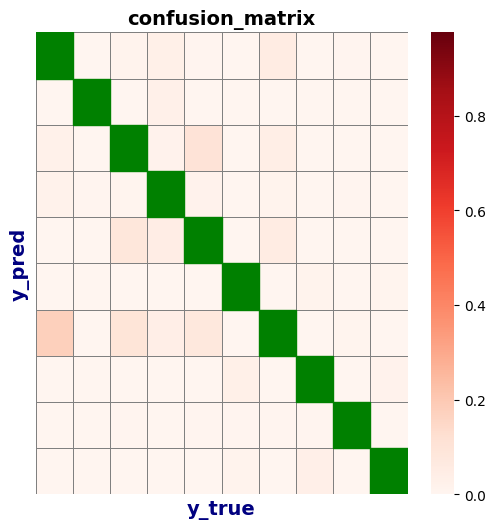

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize for better visualization
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure
plt.figure(figsize=(6, 6))

# Use a light red colormap for off-diagonal values
ax = sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Reds", linewidths=0.5, linecolor="gray")

# Manually highlight diagonal elements in green
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:  # Diagonal elements (correct predictions)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=1))

# Labels
plt.xlabel("y_true", fontsize=14, fontweight="bold", color="navy")
plt.ylabel("y_pred", fontsize=14, fontweight="bold", color="navy")
plt.title("confusion_matrix", fontsize=14, fontweight="bold")

# Remove unnecessary ticks for cleaner visualization
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()


In [ ]:
#  Agent Starting Run: g8odiz5w with config:
# wandb: 	activation: relu
# wandb: 	batch_size: 16
# wandb: 	epochs: 10
# wandb: 	hidden_layers: 5
# wandb: 	layer_size: 128
# wandb: 	learning_rate: 0.001
# wandb: 	optimizer: nadam
# wandb: 	weight_decay: 0
# wandb: 	weight_init: xavier

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Assuming you have the true and predicted labels
y_true = ...  # Replace with actual test labels
y_pred = ...  # Replace with model predictions

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# Create the heatmap with the given style
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_normalized, annot=False, cmap="RdPu", linewidths=0.5)

# Highlight the diagonal (correct classifications) in green
for i in range(len(cm)):
    for j in range(len(cm)):
        if i == j:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=0))

# Labels and title
plt.xlabel("y_true", fontsize=12, fontweight='bold')
plt.ylabel("y_pred", fontsize=12, fontweight='bold')
plt.title("confusion_matrix", fontsize=14)

# Show the plot
plt.show()


#Question 9

In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-hyperparam-tuning")
wandb.agent(sweep_id, function="squared_error", count=300)

# Question 10

In [ ]:
import argparse
import wandb
import numpy as np

def main():
    parser = argparse.ArgumentParser(description="Train a Neural Network with wandb logging")

    # Required wandb args
    parser.add_argument("-wp", "--wandb_project", type=str, default="myprojectname", help="Wandb project name")
    parser.add_argument("-we", "--wandb_entity", type=str, default="myname", help="Wandb entity name")

    # Training hyperparameters
    parser.add_argument("-d", "--dataset", type=str, choices=["mnist", "fashion_mnist"], default="fashion_mnist", help="Dataset to use")
    parser.add_argument("-e", "--epochs", type=int, default=10, help="Number of epochs")
    parser.add_argument("-b", "--batch_size", type=int, default=32, help="Batch size")
    parser.add_argument("-l", "--loss", type=str, choices=["mean_squared_error", "cross_entropy"], default="cross_entropy", help="Loss function")
    parser.add_argument("-o", "--optimizer", type=str, choices=["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"], default="adam", help="Optimizer")
    parser.add_argument("-lr", "--learning_rate", type=float, default=0.001, help="Learning rate")
    parser.add_argument("-m", "--momentum", type=float, default=0.9, help="Momentum for optimizers")
    parser.add_argument("-beta", "--beta", type=float, default=0.9, help="Beta for RMSprop")
    parser.add_argument("-beta1", "--beta1", type=float, default=0.9, help="Beta1 for Adam/Nadam")
    parser.add_argument("-beta2", "--beta2", type=float, default=0.999, help="Beta2 for Adam/Nadam")
    parser.add_argument("-eps", "--epsilon", type=float, default=1e-6, help="Epsilon for optimizers")
    parser.add_argument("-w_d", "--weight_decay", type=float, default=0.0005, help="Weight decay")
    parser.add_argument("-w_i", "--weight_init", type=str, choices=["random", "Xavier"], default="Xavier", help="Weight initialization")
    parser.add_argument("-nhl", "--num_layers", type=int, default=4, help="Number of hidden layers")
    parser.add_argument("-sz", "--hidden_size", type=int, default=64, help="Hidden layer size")
    parser.add_argument("-a", "--activation", type=str, choices=["identity", "sigmoid", "tanh", "ReLU"], default="ReLU", help="Activation function")

    args = parser.parse_args()

    # Initialize wandb
    wandb.init(project=args.wandb_project, entity=args.wandb_entity, config=vars(args))

    # Load dataset
    x_train, y_train_ohe, x_val, y_val_ohe, x_test, y_test_ohe = load_data(args.dataset)

    # Define model
    model = NeuralNetwork(
        layers=[784] + [args.hidden_size]*args.num_layers + [10],
        learning_rate=args.learning_rate,
        optimizer=args.optimizer,
        weight_decay=args.weight_decay,
        weight_init=args.weight_init,
        activation=args.activation,
        loss=args.loss
    )

    # Train model
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=args.epochs, batch_size=args.batch_size)

    # Evaluate model
    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    # Log final results
    wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    wandb.finish()

if __name__ == "__main__":
    main()
